In [ ]:
%run MUSE_spaxel_fit.py FCC177

In [ ]:
%whos
%who_ls


## Start Here

In [1]:
galaxy_name = "FCC193"

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.io import ascii, fits
from astropy.wcs import WCS, utils, wcs
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
import lmfit
import pandas as pd
from tqdm import tqdm
from photutils import CircularAperture
from IPython.display import display
from MUSE_Models import PNe_residuals_3D, PNe_spectrum_extractor, PNextractor, PSF_residuals_3D, robust_sigma
from PNLF import open_data, reconstructed_image, completeness
import yaml
import sep
from photutils import CircularAperture
import scipy as sp
from scipy.stats import norm, chi2
from scipy import stats
from ppxf_gal_L import ppxf_L_tot
from astroquery.vizier import Vizier

# look into Pandas_profiling and cufflinks

%config InlineBackend.figure_format = 'retina'

In [3]:
# functions
# Open Fits file and assign to raw_data

RAW_DIR = "/local/tspriggs/Fornax_data_cubes/"+galaxy_name
DATA_DIR = "galaxy_data/"+galaxy_name+"_data/"
EXPORT_DIR = "exported_data/"+galaxy_name+"/"
PLOT_DIR = "Plots/"+galaxy_name+"/"+galaxy_name

hdulist = fits.open(DATA_DIR+galaxy_name+"_residuals_list.fits")
hdr = hdulist[0].header
wavelength = np.exp(hdulist[1].data)
    
x_data = hdr["XAXIS"]
y_data = hdr["YAXIS"]

n_pixels = 9    # minicube FOV in pixels
c = 299792458.0 # speed of light

coordinates = [(n,m) for n in range(n_pixels) for m in range(n_pixels)]
x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])


# Load in data files for galaxy, from spaxel by spaxel fit

In [4]:
# Pull out the 1D flux data from 1D fits to do radial comparison

gauss_1D_A = np.load(EXPORT_DIR+galaxy_name+"_gauss_A_cen.npy")
A_rN_plot = np.load(EXPORT_DIR+galaxy_name+"_A_rN_cen.npy")

gauss_A_shape = gauss_1D_A.reshape(y_data, x_data)
rN = np.load(EXPORT_DIR+galaxy_name+"_rN.npy")
rN_shape = rN.reshape(y_data,x_data)
#rN_shape[np.isnan(rN_shape)] = 0

Flux_1D = gauss_1D_A * np.sqrt(2*np.pi) * 1.19
Flux_1D_cube = Flux_1D.reshape(y_data, x_data)
A_rN_plot_shape = A_rN_plot.reshape(y_data, x_data)

#PNe_1D_flux_data = np.array([PNextractor(x, y, n_pixels, Flux_1D_cube, dim=1.0) for x,y in zip(x_PNe,y_PNe)])
#PNe_1D_A_rN_data = np.array([PNextractor(x, y, n_pixels, A_rN_plot_shape, dim=1.0) for x,y in zip(x_PNe,y_PNe)])

In [5]:
with open("galaxy_info.yaml", "r") as yaml_data:
    galaxy_info = yaml.load(yaml_data, Loader=yaml.FullLoader)
    
galaxy_data = galaxy_info[galaxy_name]

emission_dict = galaxy_data["emissions"]

#D = galaxy_data["Distance"]
gal_vel = galaxy_data["velocity"]
z = gal_vel*1e3 / c

gal_mask_params = galaxy_data["gal_mask"]
star_mask_params = galaxy_data["star_mask"]

# SEP - Source Detection

In [ ]:
# new FCC167 - [237,200,150,70,0.12]

A_rN_plot_shape[A_rN_plot_shape == A_rN_plot_shape[0,0]] = 0.0
plt.figure(figsize=(20,20))

Y, X = np.mgrid[:y_data, :x_data]
xe, ye, length, width, alpha = gal_mask_params

elip_mask_gal = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (width/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2)) ** 2 <= 1    

star_mask = np.sum([(Y - yc)**2 + (X - xc)**2 <= rc**2 for xc,yc,rc in star_mask_params],0).astype(bool)

objects = sep.extract(A_rN_plot_shape, thresh=2.0, clean=True, mask=elip_mask_gal+star_mask,)# filter_type="matched", minarea=7)
x_sep = objects["x"]
y_sep = objects["y"]

positions = (x_sep, y_sep)
apertures = CircularAperture(positions, r=4)
plt.figure(figsize=(16,16))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=8.)
#plt.imshow(Flux_1D_cube, origin="lower", cmap="CMRmap", vmax=100)
apertures.plot(color="green")

plt.xlim(0,450)
plt.ylim(0,450)

ax = plt.gca()
elip_gal = Ellipse((xe, ye), width, length, angle=alpha*(180/np.pi), fill=False, color="white")
ax.add_artist(elip_gal)

sep_x_y_list = [[x,y] for x,y in zip(x_sep, y_sep)]
print(len(x_sep))

#np.save(EXPORT_DIR+galaxy_name+"_PNe_x_y_list", sep_x_y_list)

In [6]:
x_y_list = np.load(EXPORT_DIR+galaxy_name+"_PNe_x_y_list.npy")
x_PNe = np.array([x[0] for x in x_y_list])
y_PNe = np.array([y[1] for y in x_y_list])

PNe_spectra = np.array([PNe_spectrum_extractor(x, y, n_pixels, hdulist[0].data, x_data, wave=wavelength) for x,y in zip(x_PNe, y_PNe)])

PNe_df = pd.DataFrame(columns=("PNe number", "Ra (J2000)", "Dec (J2000)", "V (km/s)", "m 5007", "M 5007", "[OIII] Flux", "M 5007 error","A/rN", "rad D", "redchi", "Filter"))
PNe_df["PNe number"] = np.arange(0,len(x_PNe)) # PNe numbers
PNe_df["Filter"] = "Y"

# Objective Residual Cube
obj_residual_cube = fits.open(EXPORT_DIR+galaxy_name+"_resids_obj.fits")

# Data Residual Cube
data_residual_cube = fits.open(EXPORT_DIR+galaxy_name+"_resids_data.fits")


def uncertainty_cube_construct(data, x_P, y_P, n_pix):
    data[data == np.inf] = 0.01
    extract_data = np.array([PNe_spectrum_extractor(x, y, n_pix, data, x_data, wave=wavelength) for x,y in zip(x_P, y_P)])
    array_to_fill = np.zeros((len(x_P), n_pix*n_pix, len(wavelength)))
    for p in np.arange(0, len(x_P)):
        list_of_std = np.abs([robust_sigma(dat) for dat in extract_data[p]])
        array_to_fill[p] = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0, len(list_of_std))]
  
    return array_to_fill

error_cube = uncertainty_cube_construct(data_residual_cube[0].data, x_PNe, y_PNe, n_pixels)
obj_error_cube = uncertainty_cube_construct(obj_residual_cube[0].data, x_PNe, y_PNe, n_pixels)

/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/MUSE_Models.py:119: RuntimeWarning: invalid value encountered in true_divide
  u2 = (d/(9.0*mad))**2  # c = 9
/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/MUSE_Models.py:120: RuntimeWarning: invalid value encountered in less
  good = u2 < 1.0
/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/MUSE_Models.py:124: RuntimeWarning: invalid value encountered in double_scalars
  sigma = np.sqrt(num/(den*(den - 1.0)))  # see note in above reference


In [7]:
PNe_multi_params = Parameters()

def gen_params(wave=5007, FWHM=4.0, FWHM_err=0.1, beta=2.5, beta_err=0.3, LSF=2.81, em_dict=None, vary_LSF=False, vary_PSF=False):
    # loop through emission dictionary to add different element parameters 
    for em in em_dict:
        #Amplitude params for each emission
        PNe_multi_params.add('Amp_2D_{}'.format(em), value=emission_dict[em][0], min=0.00001, max=1e5, expr=emission_dict[em][1])
        #Wavelength params for each emission
        if emission_dict[em][2] == None:
            PNe_multi_params.add("wave_{}".format(em), value=wave, min=wave-25., max=wave+25.)
        else:
            PNe_multi_params.add("wave_{}".format(em), expr=emission_dict[em][2].format(z))
    
    PNe_multi_params.add("x_0", value=(n_pixels/2.), min=(n_pixels/2.) -3, max=(n_pixels/2.) +3)
    PNe_multi_params.add("y_0", value=(n_pixels/2.), min=(n_pixels/2.) -3, max=(n_pixels/2.) +3)
    PNe_multi_params.add("LSF", value=LSF, vary=vary_LSF, min=LSF-1, max=LSF+1)
    PNe_multi_params.add("M_FWHM", value=FWHM, min=FWHM - FWHM_err, max=FWHM + FWHM_err, vary=vary_PSF)
    PNe_multi_params.add("beta", value=beta, min=beta - beta_err, max=beta + beta_err, vary=vary_PSF)   
    PNe_multi_params.add("Gauss_bkg",  value=0.001, vary=True)#1, min=-200, max=500)
    PNe_multi_params.add("Gauss_grad", value=0.0001, vary=True)#1, min=-2, max=2)
    
# storage setup
total_Flux = np.zeros((len(x_PNe),len(emission_dict)))
A_2D_list = np.zeros((len(x_PNe),len(emission_dict)))
F_xy_list = np.zeros((len(x_PNe), len(emission_dict), len(PNe_spectra[0])))
moff_A = np.zeros((len(x_PNe),len(emission_dict)))
model_spectra_list = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))
mean_wave_list = np.zeros((len(x_PNe),len(emission_dict)))
residuals_list = np.zeros(len(x_PNe))
list_of_fit_residuals = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))
chi_2_r = np.zeros((len(x_PNe)))
lmfit_chi2 = np.ones(len(x_PNe))

# error lists
moff_A_err = np.zeros((len(x_PNe), len(emission_dict)))
x_0_err = np.zeros((len(x_PNe), len(emission_dict)))
y_0_err = np.zeros((len(x_PNe), len(emission_dict)))
mean_wave_err = np.zeros((len(x_PNe), len(emission_dict)))
Gauss_bkg_err = np.zeros((len(x_PNe), len(emission_dict)))
Gauss_grad_err = np.zeros((len(x_PNe), len(emission_dict)))

list_of_x = np.zeros(len(x_PNe))
list_of_y = np.zeros(len(x_PNe))
Gauss_bkg = np.zeros(len(x_PNe))
Gauss_grad = np.zeros(len(x_PNe))

def run_minimiser(parameters):
    for PNe_num in tqdm(np.arange(0, len(x_PNe))):
        #progbar(int(PNe_num)+1, len(x_PNe), 40)
        useful_stuff = []        
        PNe_minimizer     = lmfit.Minimizer(PNe_residuals_3D, PNe_multi_params, fcn_args=(wavelength, x_fit, y_fit, PNe_spectra[PNe_num], error_cube[PNe_num], PNe_num, emission_dict, useful_stuff), nan_policy="propagate")
        multi_fit_results = PNe_minimizer.minimize(method="least_squares")
        total_Flux[PNe_num] = np.sum(useful_stuff[1][1],1) * 1e-20
        list_of_fit_residuals[PNe_num] = useful_stuff[0]
        A_2D_list[PNe_num]  = useful_stuff[1][0]
        F_xy_list[PNe_num]  = useful_stuff[1][1]
        model_spectra_list[PNe_num] = useful_stuff[1][3]
        moff_A[PNe_num]  = [multi_fit_results.params["Amp_2D_{}".format(em)] for em in emission_dict]
        mean_wave_list[PNe_num]     = [multi_fit_results.params["wave_{}".format(em)] for em in emission_dict]   
        chi_2_r[PNe_num]    = multi_fit_results.redchi
        list_of_x[PNe_num]  = multi_fit_results.params["x_0"]
        list_of_y[PNe_num]  = multi_fit_results.params["y_0"]
        Gauss_bkg[PNe_num]  = multi_fit_results.params["Gauss_bkg"]
        Gauss_grad[PNe_num] = multi_fit_results.params["Gauss_grad"]
        #save errors
        moff_A_err[PNe_num]     = [multi_fit_results.params["Amp_2D_{}".format(em)].stderr for em in emission_dict]
        mean_wave_err[PNe_num]  = [multi_fit_results.params["wave_{}".format(em)].stderr for em in emission_dict]
        x_0_err[PNe_num]        = multi_fit_results.params["x_0"].stderr
        y_0_err[PNe_num]        = multi_fit_results.params["y_0"].stderr
        Gauss_bkg_err[PNe_num]  = multi_fit_results.params["Gauss_bkg"].stderr
        Gauss_grad_err[PNe_num] = multi_fit_results.params["Gauss_grad"].stderr
        
        lmfit_chi2[PNe_num] = multi_fit_results.chisqr
        
        
    # Signal to noise and Magnitude calculations
    list_of_rN = np.array([robust_sigma(PNe_res) for PNe_res in list_of_fit_residuals])
    PNe_df["A/rN"] = A_2D_list[:,0] / list_of_rN # Using OIII amplitude   
    
    # chi square analysis
    gauss_list, redchi, Chi_sqr = [], [], []
    for p in range(len(x_PNe)):
        PNe_n = np.copy(PNe_spectra[p])
        flux_1D = np.copy(F_xy_list[p][0])
        A_n = ((flux_1D) / (np.sqrt(2*np.pi) * (galaxy_data["LSF"]/ 2.35482)))
    
        def gaussian(x, amplitude, mean, FWHM, bkg, grad, z):
            stddev = FWHM / 2.35482
            return ((bkg + grad*x) + np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.)) +
                    (np.abs(amplitude)/2.85) * np.exp(- 0.5 * (x - (mean - 47.9399*(1+z)))** 2 / (stddev**2.)))
    
        list_of_gauss = [gaussian(wavelength, A, mean_wave_list[p][0], galaxy_data["LSF"], Gauss_bkg[p], Gauss_grad[p], z) for A in A_n]
    
        for kk in range(len(PNe_n)):
            temp = np.copy(list_of_gauss[kk])
            idx  = np.where(PNe_n[kk] == 0.0)[0]
            temp[idx] = 0.0
            PNe_n[kk,idx] = 1.0
            list_of_gauss[kk] = np.copy(temp)
        rN   = robust_sigma(PNe_n - list_of_gauss)
        res  = PNe_n - list_of_gauss
        Chi2 = np.sum((res**2)/(rN**2))
        s    = np.shape(PNe_n)
        redchi.append(Chi2/ ((len(wavelength) * n_pixels**2) - multi_fit_results.nvarys))
        gauss_list.append(list_of_gauss)
        Chi_sqr.append(Chi2)
        
    PNe_df['Chi2']   = Chi_sqr
    PNe_df["redchi"] = redchi
    
    # velocity
    de_z_means = np.array(mean_wave_list[:,0] / (1 + z)) # de redshift OIII wavelength position
    
    PNe_df["V (km/s)"] = (c * (de_z_means - 5006.77) / 5006.77) / 1000.    
        
    PNe_df["[OIII] Flux"] = total_Flux[:,0] #store total OIII 5007 line flux
        
    if "hb" in emission_dict:
        PNe_df["[OIII]/Hb"] = PNe_df["[OIII] Flux"] / total_Flux[:,2] # store [OIII]/Hb ratio

    if "ha" in emission_dict:
        PNe_df["Ha Flux"] = total_Flux[:, 1]
    
    PNe_df["m 5007"] = -2.5 * np.log10(PNe_df["[OIII] Flux"].values) - 13.74


In [8]:
print("Running fitter")
# 5006.77*(1+z)
gen_params(wave=5006.77*(1+z), FWHM=galaxy_data["FWHM"], beta=galaxy_data["beta"], LSF=galaxy_data["LSF"], vary_PSF=False, em_dict=emission_dict)
    
run_minimiser(PNe_multi_params)

  0%|          | 0/174 [00:00<?, ?it/s]

Running fitter


100%|██████████| 174/174 [02:30<00:00,  1.16it/s]


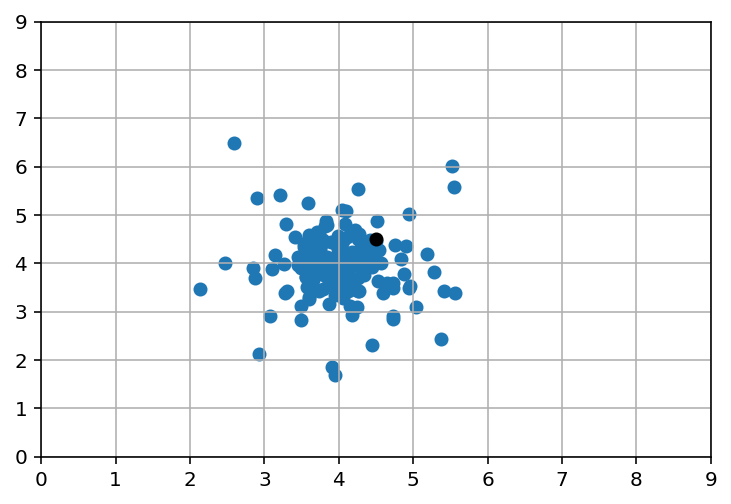

In [9]:
plt.scatter(list_of_x, list_of_y)
plt.ylim(0,9)
plt.xlim(0,9)
plt.scatter((n_pixels/2.) ,(n_pixels/2.) , c="k")
plt.grid(True)

In [10]:
print(z)

0.003255585569133964


## The Great Filter

160
143


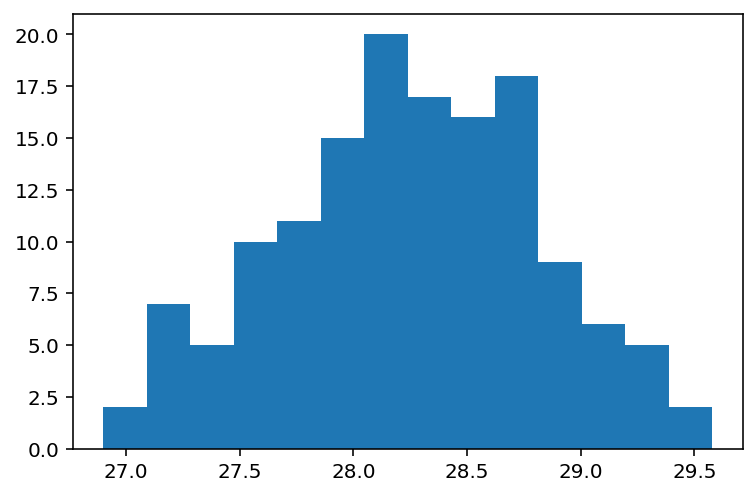

In [11]:
PNe_df["Filter"] = "Y"
PNe_df.loc[PNe_df["A/rN"]<3.0, "Filter"] = "N"
print(len(PNe_df["Filter"].loc[PNe_df["Filter"]=="Y"]))

upper_chi = chi2.ppf(0.9973, (9*9*len(wavelength))-6) # 3 sigma = 0.9973
PNe_df.loc[PNe_df["Chi2"]>=upper_chi, "Filter"] = "N" 

## FCC167
if galaxy_name == "FCC167":
    PNe_df.loc[PNe_df["PNe number"]==29, "Filter"] = "N" # Over luminous PNe
    PNe_df.loc[PNe_df["PNe number"]==15, "Filter"] = "N" # Potential HII region
    PNe_df.loc[PNe_df["PNe number"]==8, "Filter"] = "N"  # Double reading from source
## FCC219
# elif galaxy_name == "FCC219":
#     PNe_df.loc[PNe_df["PNe number"]==11, "Filter"] = "N"
elif galaxy_name == "FCC193":
    PNe_df.loc[PNe_df["PNe number"]==143, "Filter"] = "N" 
    PNe_df.loc[PNe_df["PNe number"]==141, "Filter"] = "N" 
    PNe_df.loc[PNe_df["PNe number"]==84, "Filter"] = "N"
    PNe_df.loc[PNe_df["PNe number"]==77, "Filter"] = "Y" 
    PNe_df.loc[PNe_df["PNe number"]==94, "Filter"] = "Y" 
#elif galaxy_name == "FCC147":
    #PNe_df.loc[PNe_df["PNe number"]==41, "Filter"] = "N"
# elif galaxy_name == "FCC249":
#     PNe_df.loc[PNe_df["PNe number"]==2, "Filter"] = "N"
elif galaxy_name == "FCC276":
    PNe_df.loc[PNe_df["PNe number"]==20, "Filter"] = "N" # Overly bright object, sets D=15Mpc, could be overlap/super-position of two.
    PNe_df.loc[PNe_df["PNe number"]==40, "Filter"] = "Y"
    PNe_df.loc[PNe_df["PNe number"]==79, "Filter"] = "Y"
    PNe_df.loc[PNe_df["PNe number"]==85, "Filter"] = "Y"
# elif galaxy_name == "FCC184":
#     PNe_df.loc[PNe_df["PNe number"]==15, "Filter"] = "N"
#     PNe_df.loc[PNe_df["PNe number"]==35, "Filter"] = "N"
elif galaxy_name == "FCC301":
    PNe_df.loc[PNe_df["PNe number"]==14, "Filter"] = "N"
    PNe_df.loc[PNe_df["PNe number"]==16, "Filter"] = "N"
elif galaxy_name == "FCC255":
    PNe_df.loc[PNe_df["PNe number"]==32, "Filter"] = "N"



    

print(len(PNe_df["Filter"].loc[PNe_df["Filter"]=="Y"]))
plt.hist(PNe_df["m 5007"].loc[PNe_df["Filter"]=="Y"], bins=14);
plt.show()

In [14]:
norm.fit(PNe_df["V (km/s)"].loc[PNe_df["Filter"]=="Y"].values)

(-81.78287295704204, 137.5726253273673)

# Error analysis

In [12]:
def Moffat_err(Moff_A, FWHM, beta, x_0, y_0):
    if beta <0.01:
        beta = 0.01
    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((np.array(x_fit) - x_0)**2 + (np.array(y_fit) - y_0)**2) / gamma**2
    F_OIII_xy_dist = Moff_A * (1 + rr_gg)**(-beta)
    
    return np.sum(F_OIII_xy_dist*1e-20)
    
def error_sim(n_sim, n_PNe):
    mean_flux = np.ones(n_PNe)
    flux_err  = np.ones(n_PNe)
    mean_m5007 = np.ones(n_PNe)
    m5007_err = np.ones(n_PNe)
    for n in np.arange(0,len(x_PNe)):
        Moff_A_dist = np.random.normal(moff_A[n][0], moff_A_err[n][0],n_sim)
        FWHM_dist = np.random.normal(galaxy_data["FWHM"], galaxy_data["FWHM_err"], n_sim)
        beta_dist = np.abs(np.random.normal(galaxy_data["beta"], galaxy_data["beta_err"], n_sim))
        x_0_dist = np.random.normal(list_of_x[n], x_0_err[n][0], n_sim)
        y_0_dist = np.random.normal(list_of_y[n], y_0_err[n][0], n_sim)
        
        flux_array = [Moffat_err(Moff_A_dist[i], FWHM_dist[i], beta_dist[i], x_0_dist[i], y_0_dist[i]) for i in range(0,n_sim)]

        mean_flux[n] = np.median(flux_array)
        flux_err[n] = mean_flux[n] - np.median([np.percentile(flux_array, 16), np.percentile(flux_array, 84)])
                
        mean_m5007[n] = np.median(-2.5*np.log10(flux_array)-13.72)
        m5007_err[n]  = mean_m5007[n] - np.median([np.percentile((-2.5*np.log10(flux_array)-13.72), 16),
                                   np.percentile((-2.5*np.log10(flux_array)-13.72), 84)])

    return mean_flux, flux_err, mean_m5007, m5007_err

mean_flux, PNe_df["Flux error"], mean_m5007, PNe_df["m 5007 error"] = error_sim(5000, len(x_PNe))

## Show F_err in percentage terms
PNe_df["F[OIII] err percent"] = (PNe_df["Flux error"] / PNe_df["[OIII] Flux"])*100

## Distance estimate with error

In [13]:
p_n = int(PNe_df.loc[PNe_df["Filter"]=="Y"].nsmallest(1, "m 5007").index.values)
flux = PNe_df["[OIII] Flux"].iloc[p_n]
flux_err = PNe_df["Flux error"].iloc[p_n]
m = PNe_df["m 5007"].iloc[p_n]
m_err = PNe_df["m 5007 error"].iloc[p_n]
print("PNe: ", p_n)

M_star = -4.52
M_star_err = 0.08
D_diff_eq = 0.2 * np.log(10) * (10**(0.2*(m + 4.52 - 25)))

Dist_est = 10.**(((m + 4.52) -25.) / 5.)#17.54
Dist_err = np.sqrt((D_diff_eq**2 * m_err**2) + ((-D_diff_eq)**2 * M_star_err**2))

print("Distance Estimate from PNLF: ", "{:.3f}".format(Dist_est), "+/-{0:.4f}".format(Dist_err),"Mpc")

dM =  5. * np.log10(Dist_est) + 25.
dM_diff_eq = 5/(np.log(10) * Dist_est)
dM_err = np.abs(dM_diff_eq)*Dist_err

print("dM = {:.3f}".format(dM),"+/- {:.3f}".format(dM_err))

PNe_df["M 5007"] = PNe_df["m 5007"] - dM

PNe:  77
Distance Estimate from PNLF:  19.231 +/-0.7085 Mpc
dM = 31.420 +/- 0.080


In [12]:
PNe_df.to_csv(f"exported_data/{galaxy_name}/{galaxy_name}_PNe_df.csv")

Text(360, 375, 'E')

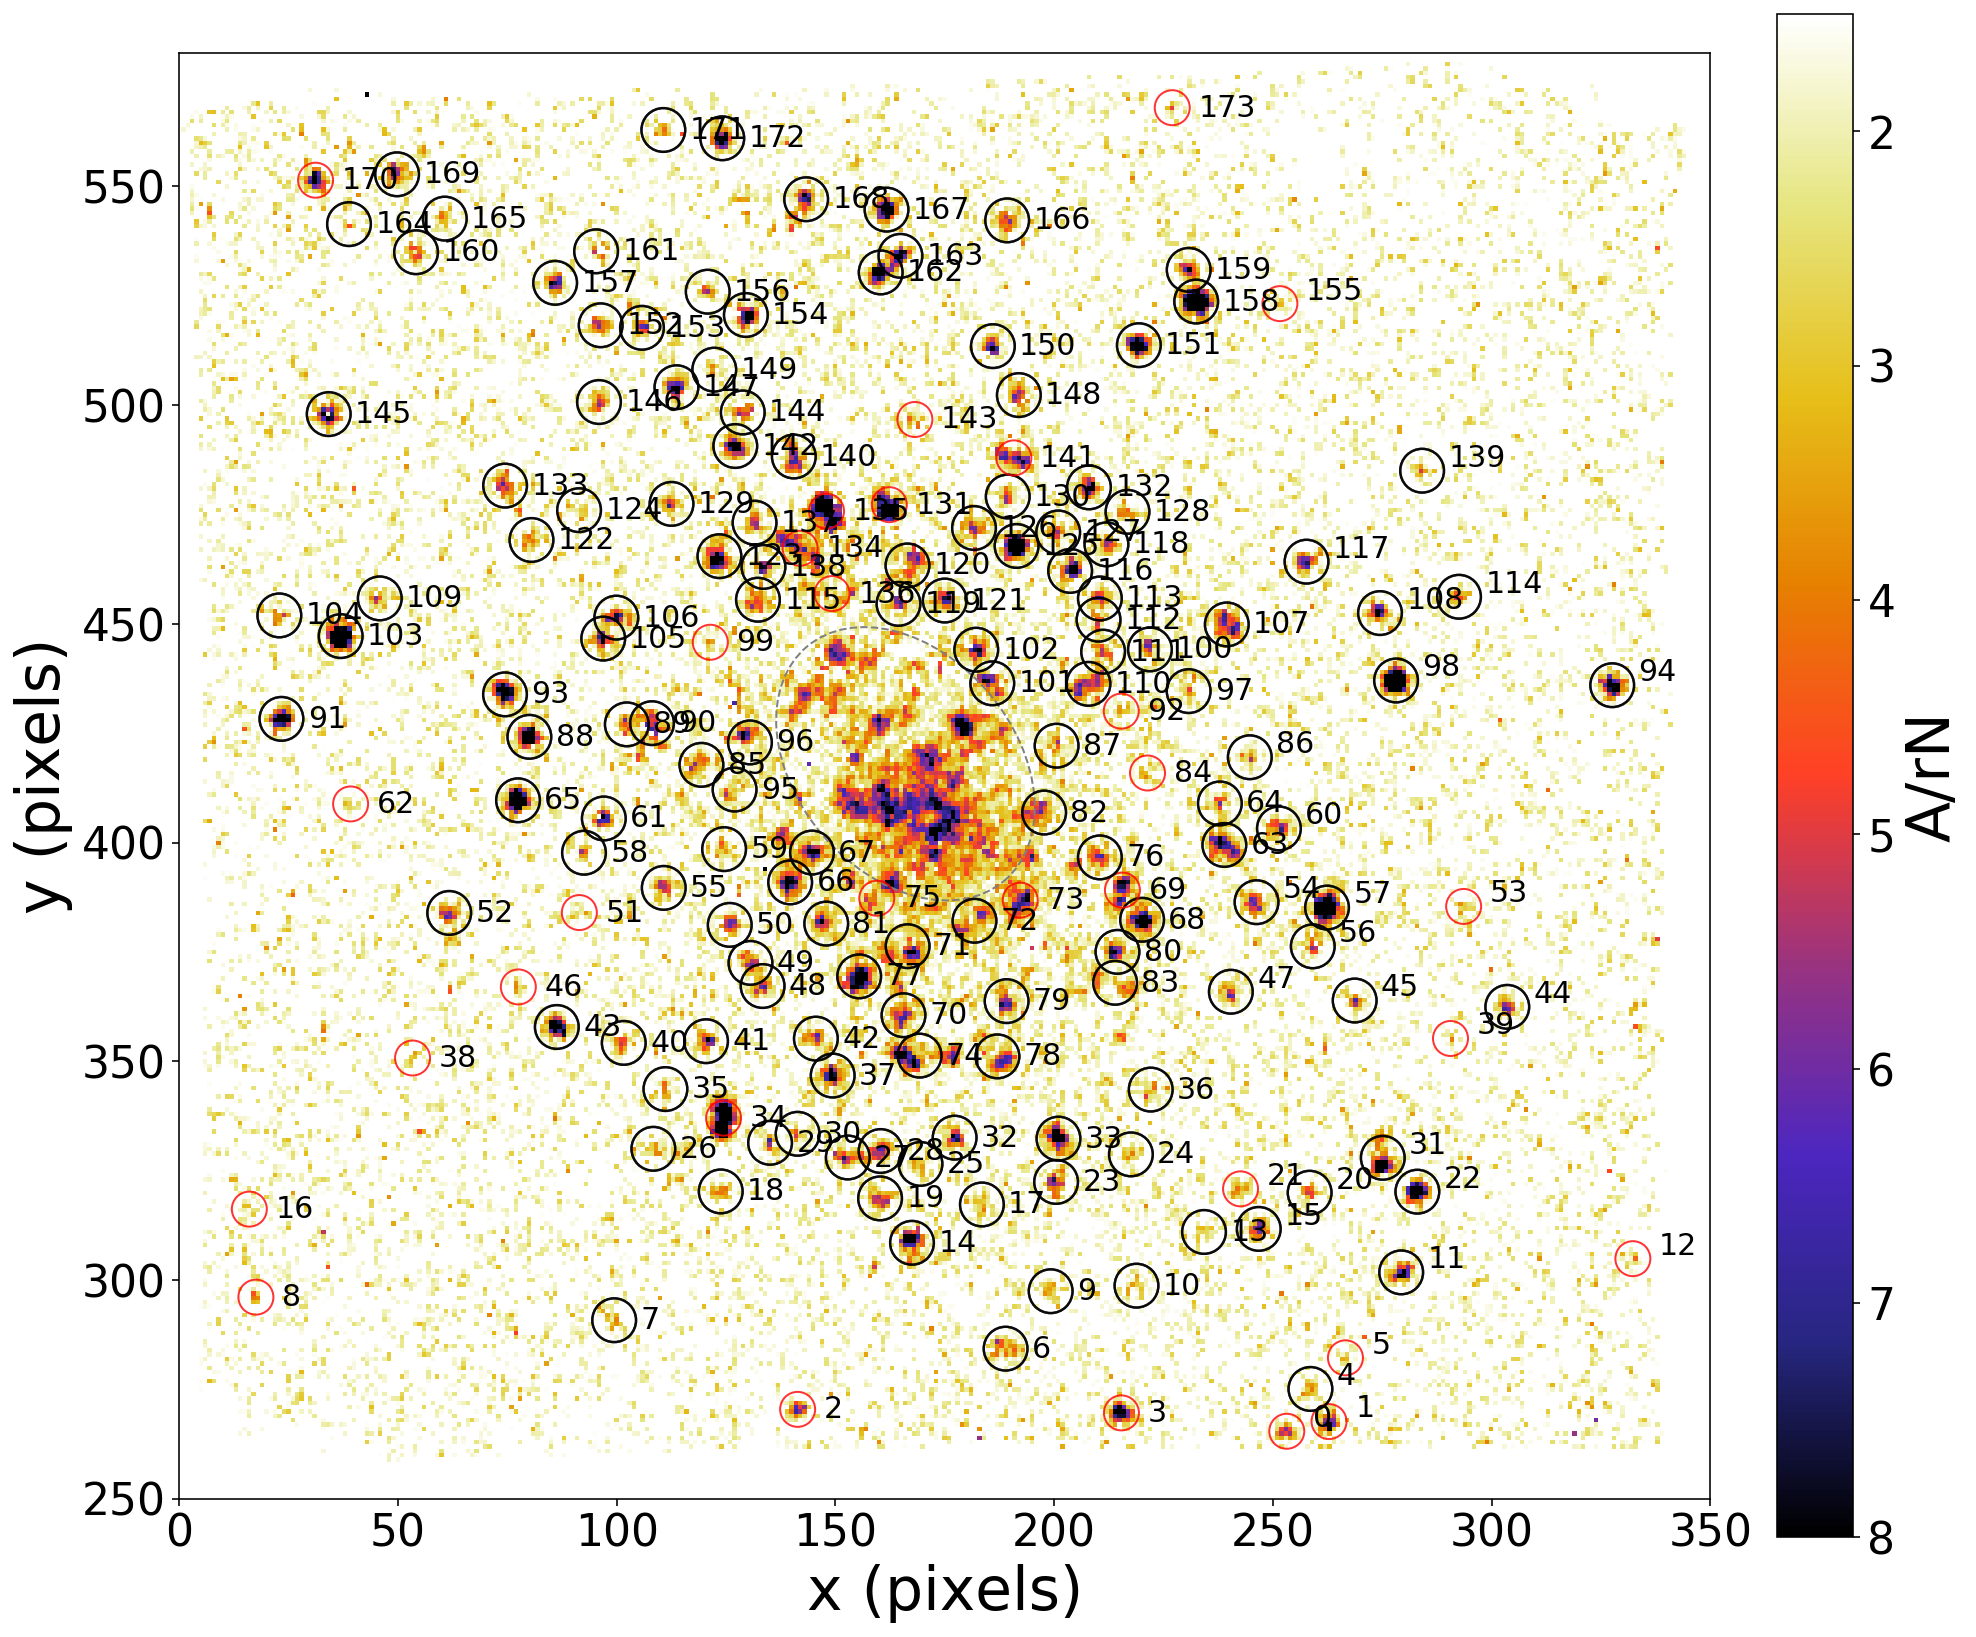

In [14]:
plt.figure(figsize=(15,15))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap_r",  vmin=1.5, vmax=8)
#plt.imshow(Flux_1D_cube, origin="lower", cmap="CMRmap",  vmin=10, vmax=150)
ax = plt.gca()
cb=plt.colorbar(fraction=0.0455, pad=0.04)
cb.set_label("A/rN",fontsize=30)
cb.ax.tick_params(labelsize=22)
cb.ax.invert_yaxis()


plt.xlabel("x (pixels)", fontsize=30)
plt.ylabel("y (pixels)", fontsize=30)

plt.tick_params(labelsize = 22)

Y, X = np.mgrid[:y_data, :x_data]
xe, ye, length, width, alpha = gal_mask_params

if galaxy_name=="FCC219":
    plt.ylim(0,440)
    plt.xlim(0,440)
elif galaxy_name=="FCC193":
    plt.ylim(250,)
    plt.xlim(0,350)
elif galaxy_name=="FCC161":
    plt.xlim(0,450)
elif galaxy_name=="FCC147":
    plt.xlim(230,)
    plt.ylim(0,320)
elif galaxy_name=="FCC083":
    plt.xlim(0,370)
    plt.ylim(0,370)
elif galaxy_name=="FCC310":
    plt.xlim(0,410)
    plt.ylim(100,)
elif galaxy_name=="FCC276":
    plt.xlim(310,)
elif galaxy_name=="FCC184":
    plt.xlim(0,450)
    plt.ylim(0,450)

elip_gal = Ellipse((xe, ye), width, length, angle=alpha*(180/np.pi), fill=False, color="grey", ls="--")
ax.add_artist(elip_gal)

for star in star_mask_params:
    ax.add_artist(Circle((star[0], star[1]), radius=star[2], fill=False, color="grey", ls="--"))



for i, item in enumerate(x_y_list):
    if PNe_df.iloc[i].Filter == "Y":
        ax = plt.gca()
        circ = plt.Circle((item[0],item[1]),5, color="black",lw=1.2, fill=False, alpha=0.8)
        ax.add_artist(circ)
    elif PNe_df.iloc[i].Filter == "N":
        ax = plt.gca()
        circ = plt.Circle((item[0],item[1]),4, color="red",lw=1., fill=False, alpha=0.8)
    ax.add_artist(circ)
    if item[0]<240.:
        ax.annotate(i, (item[0]+6, item[1]-2), color="black", size=15)
    else:
        ax.annotate(i, (item[0]+6, item[1]+1), color="black", size=15)

plt.arrow(400,380, 0,30, head_width=5, width=0.5, color="k")
plt.annotate("N", xy=(395, 420), fontsize=25)
plt.arrow(400,380, -20,0, head_width=5, width=0.5, color="k")
plt.annotate("E", xy=(360, 375), fontsize=25)

# for i in contamination:
#     ax = plt.gca()
#     circ = plt.Circle((x_PNe[i],y_PNe[i]),6, color="r",lw=1.0, fill=False, alpha=0.7)
#     ax.add_artist(circ)
    
#plt.axvline(190)
#plt.axhline(110)
# plt.savefig(PLOT_DIR+"_A_rN_circled.png", bbox_inches='tight')
#plt.savefig(PLOT_DIR+"_A_rN_circled.pdf", bbox_inches='tight')
#plt.savefig(PLOT_DIR+"_Flux_circled.pdf", bbox_inches='tight')

## Pixel array size experiment

In [ ]:
# n_pix_dist = 31
n_range = np.arange(11,22,2)
store_here = np.ones(len(n_range))
for i, n_pix_dist in enumerate(n_range):
    coordinates = [(n,m) for n in range(n_pix_dist) for m in range(n_pix_dist)]
    x_fit = np.array([item[0] for item in coordinates])
    y_fit = np.array([item[1] for item in coordinates])
    
    n_sim = 10000
    Moff_A_dist = np.random.normal(moff_A[40][0], moff_A_err[40][0],n_sim)
    FWHM_dist = np.random.normal(4.06, 0.018, n_sim)
    beta_dist = np.random.normal(3.41, 0.167, n_sim)
    x_0_dist = np.random.normal(list_of_x[40], x_0_err[40][0], n_sim)
    y_0_dist = np.random.normal(list_of_y[40], y_0_err[40][0], n_sim)
    
    def Moffat_err(Moff_A, FWHM, beta, x_0, y_0):
        gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
        rr_gg = ((np.array(x_fit) - x_0)**2 + (np.array(y_fit) - y_0)**2) / gamma**2
        F_OIII_xy_dist = Moff_A * (1 + rr_gg)**(-beta)
    
    
        return np.sum(F_OIII_xy_dist*1e-20)
    
    flux_array = [Moffat_err(Moff_A_dist[i], FWHM_dist[i], beta_dist[i], x_0_dist[i], y_0_dist[i]) for i in range(0,n_sim)]
    plt.hist(flux_array)
    plt.axvline(PNe_df["[OIII] Flux"].iloc[40])
    #plt.xlim(3.6e-17, 4.2e-17)
    #print(PNe_df["[OIII] Flux"].iloc[40])
    #print(PNe_df["m 5007"].iloc[40])
    mu_f, std_f = norm.fit(flux_array)
    #print(mu, (std/mu)*100,"%")
    plt.axvline(mu_f, c="r")
    
    mu, std = norm.fit(-2.5*np.log10(flux_array)-13.72)
    #print(mu, std)
    store_here[i] = mu_f

print(np.abs((-2.5*np.log10(store_here.max()) - 13.74)  -  (-2.5*np.log10(store_here[1]) - 13.74)))

plt.figure()
plt.plot(n_range, store_here)
plt.axvline(n_pixels)
# Correction for n_pixel and flux variation from fit

## Integrated spectrum with fit

18254.588460686387
15547.340219191157


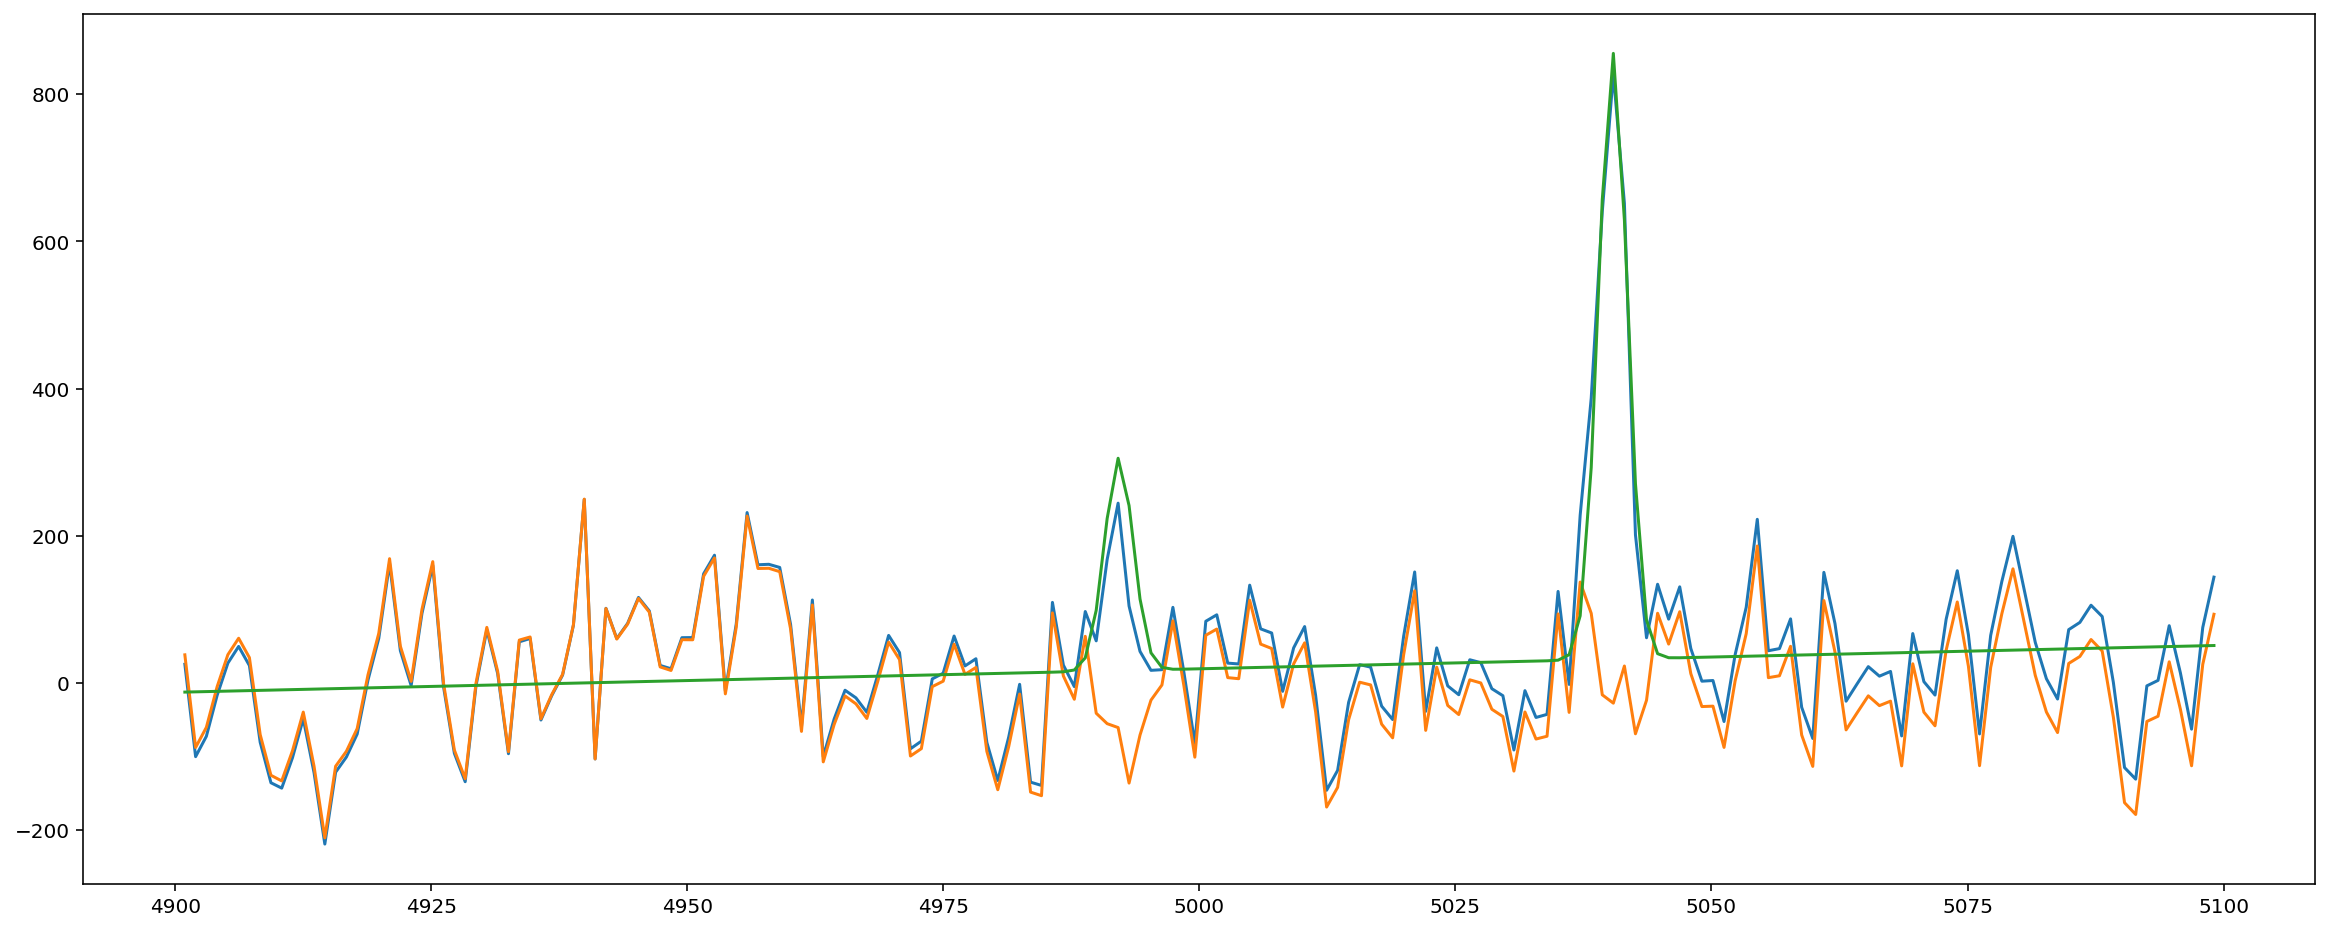

In [39]:
p = 51
res = PNe_spectra[p] - model_spectra_list[p]
plt.figure(figsize=(20,8))
plt.plot(wavelength, np.sum(PNe_spectra[p],0))
plt.plot(wavelength, np.sum(res, 0))
plt.plot(wavelength, np.sum(model_spectra_list[p], 0))
print(PNe_df["Chi2"].iloc[p])
print(upper_chi)

PNe number                      51
Ra (J2000)                     NaN
Dec (J2000)                    NaN
V (km/s)                   133.292
m 5007                     27.6088
M 5007                    -3.80348
[OIII] Flux            2.88715e-17
M 5007 error                   NaN
A/rN                       5.77221
rad D                          NaN
redchi                     1.21212
Filter                           N
Chi2                       18254.6
Flux error            -1.40254e-22
m 5007 error           -0.00184966
F[OIII] err percent   -0.000485789
Name: 51, dtype: object


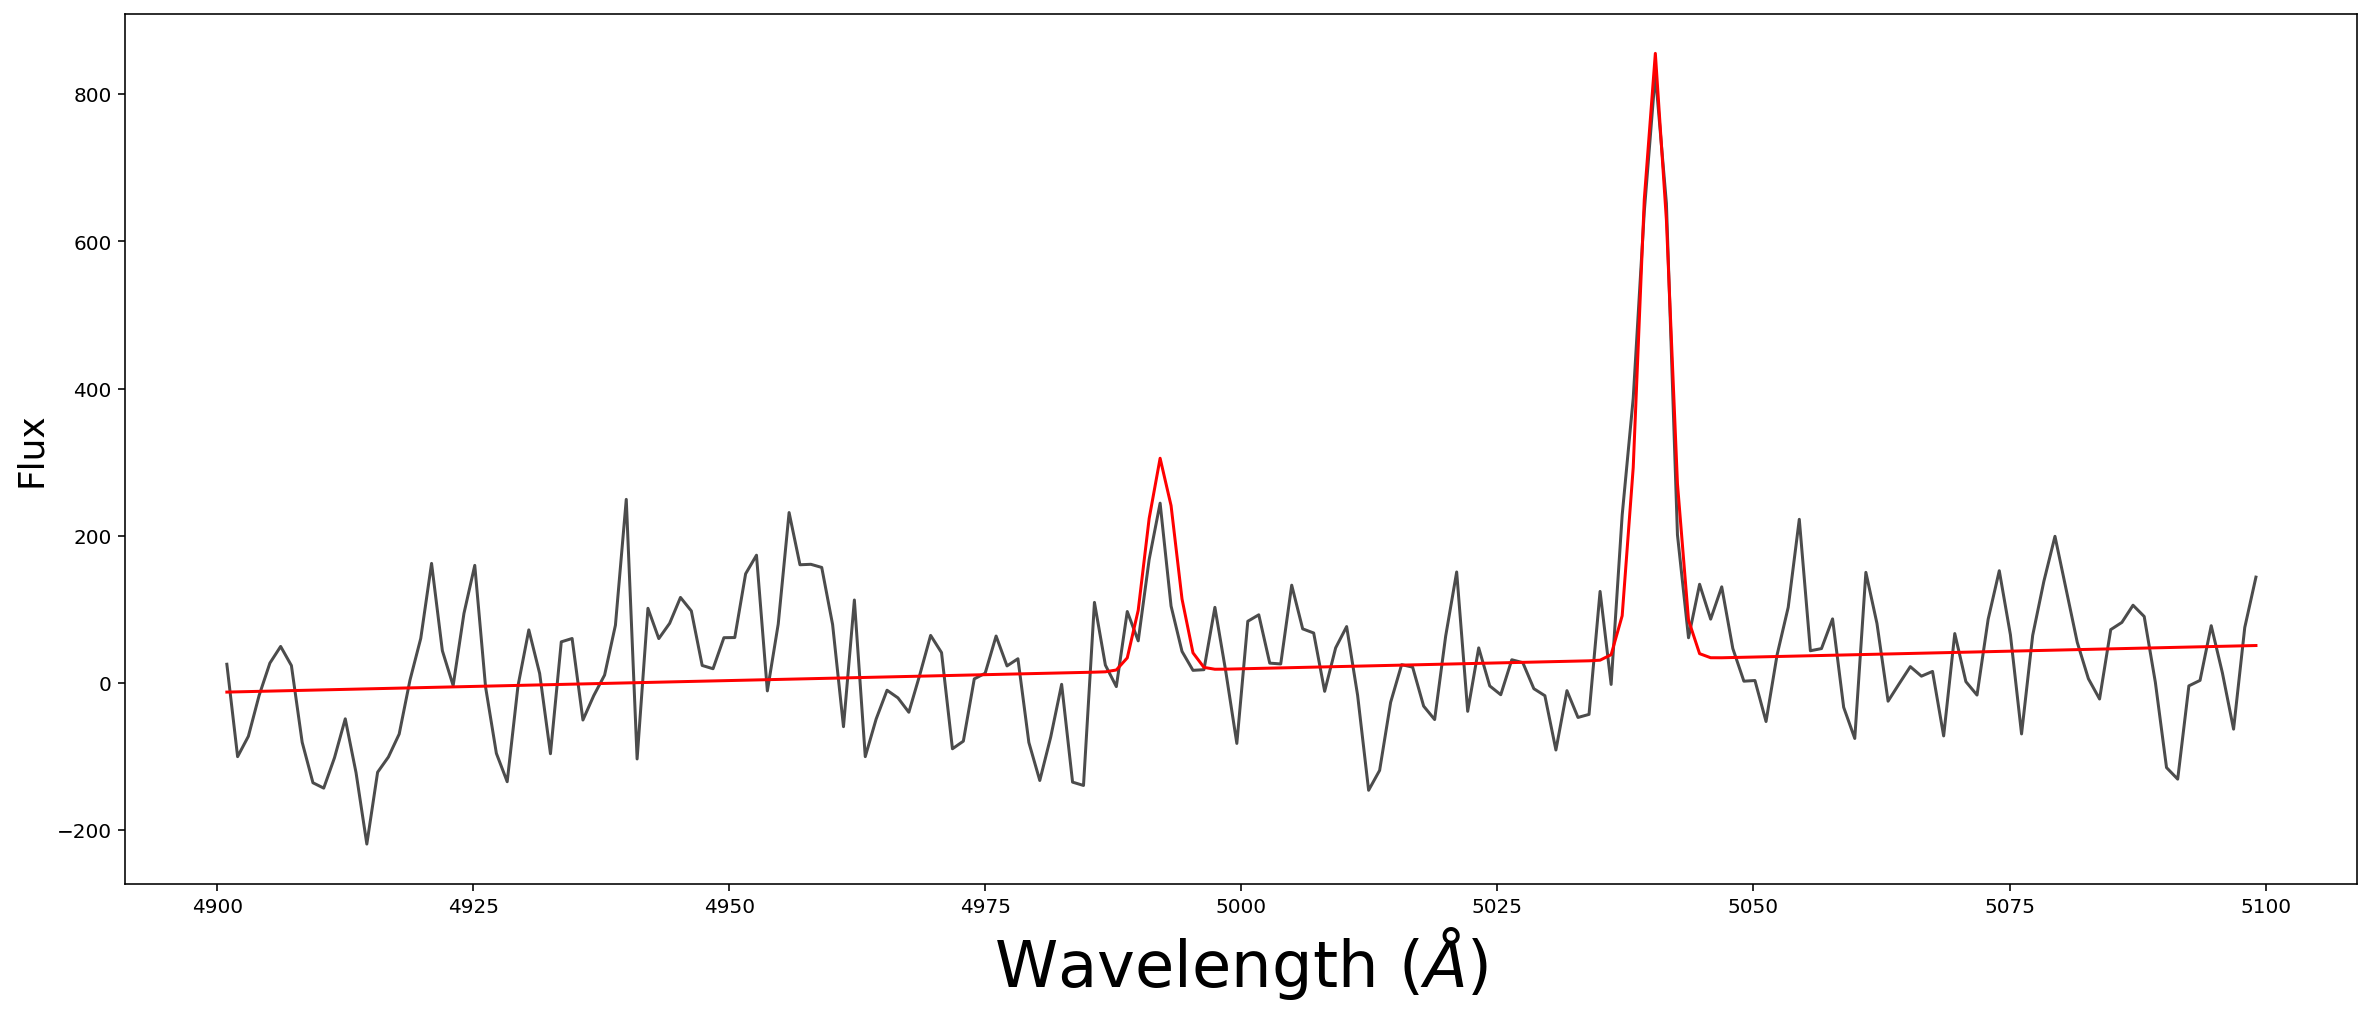

In [28]:
p = 51

print(PNe_df.loc[p])

plt.figure(figsize=(20,8))
plt.plot(wavelength, np.sum(PNe_spectra[p],0), alpha=0.7, c="k")

plt.plot(wavelength, np.sum(model_spectra_list[p],0), c="r")
plt.xlabel("Wavelength ($\AA$)", fontsize=32)
plt.ylabel("Flux", fontsize=18);
#plt.ylim(-1000,3500);
#plt.axvline(5042)
#plt.xlim(4900,5100)
#plt.axvline(5039)
#plt.axvline(5033)
plt.savefig(PLOT_DIR+f"_integrated_PNe_{p}_fit.png")

## Spaxel by spaxel with individual fits

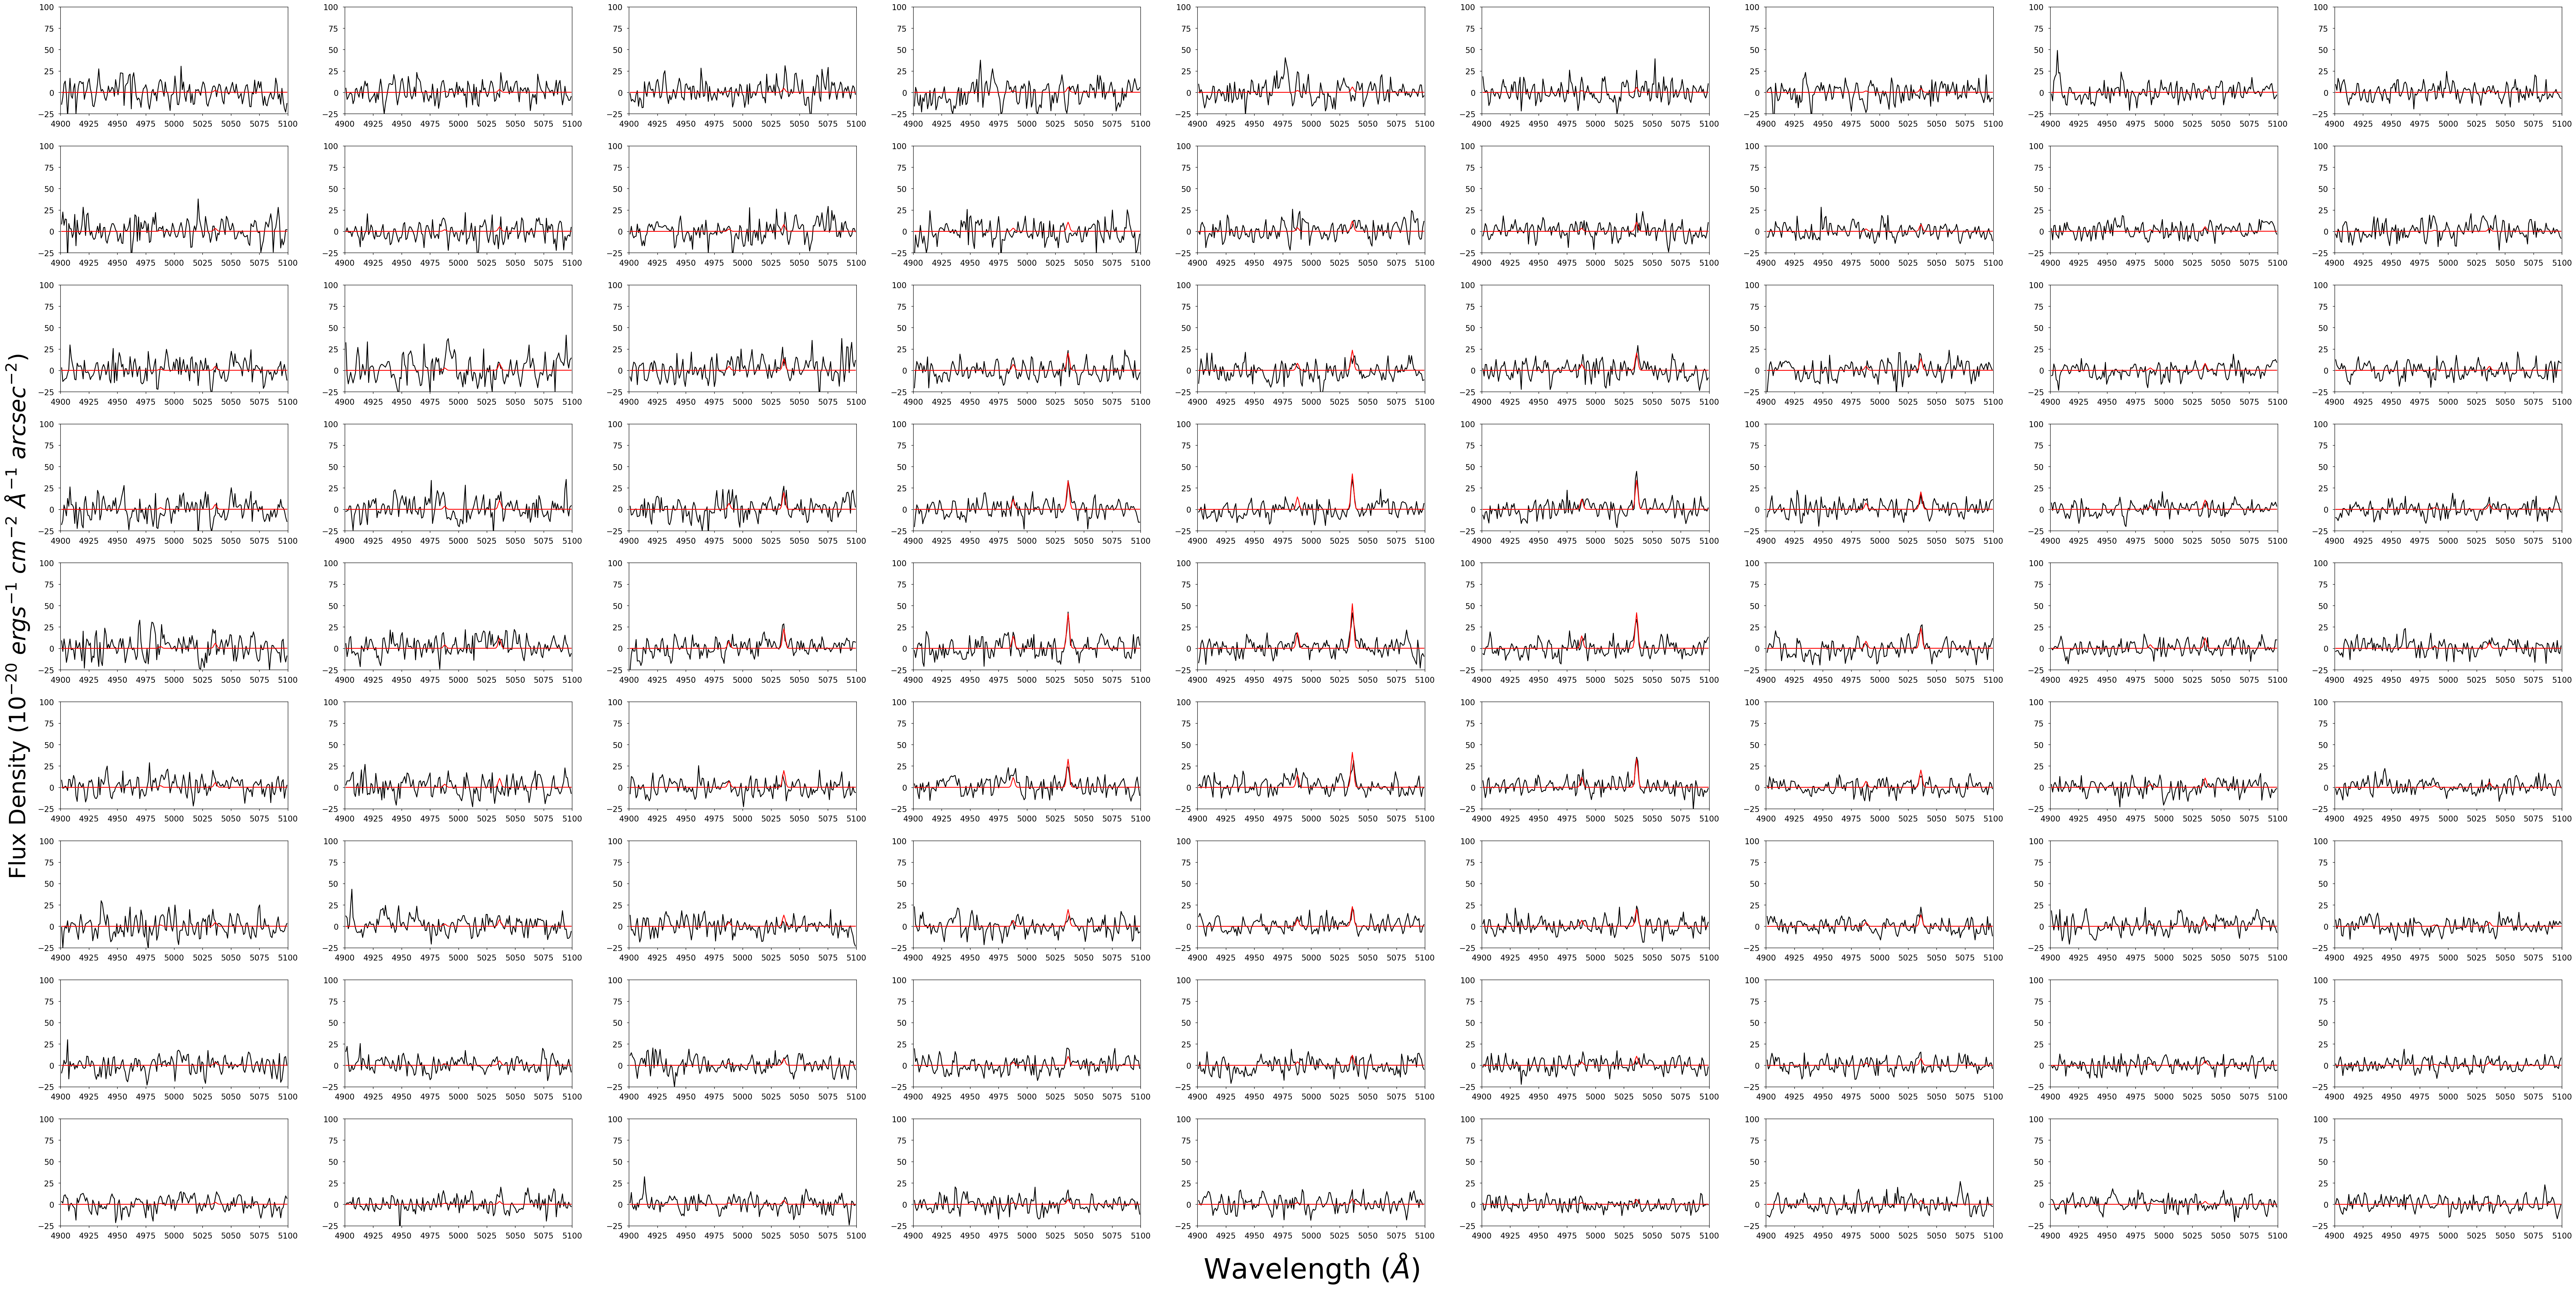

In [13]:
p = 3
PNe_n = PNe_spectra[p]
flux_1D = F_xy_list[p][0]
A_n = ((flux_1D) / (np.sqrt(2*np.pi) * 1.19))

def gaussian(x, amplitude, mean, stddev, bkg, grad, z):
    return (bkg + grad*x + np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.)) +
            (np.abs(amplitude)/2.85) * np.exp(- 0.5 * (x - (mean - 47.9399*(1+z)))** 2 / (stddev**2.)))

list_of_gauss = [gaussian(wavelength, A, mean_wave_list[p][0], 1.19, Gauss_bkg[p], Gauss_grad[p], z) for A in A_n]

fig = plt.figure(figsize=(80,40))

ax = fig.add_subplot(1,1,1)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)


for i, spec in enumerate(PNe_n):
    ax1 = fig.add_subplot(n_pixels,n_pixels,i+1)
    fig.subplots_adjust(wspace=0.25, hspace=0.3)
    ax1.plot(wavelength, spec, c="k")
    ax1.plot(wavelength, list_of_gauss[i], c="r", alpha=1.0)
    ax1.tick_params(labelsize = 14, pad=8)
    ax1.set_xlim(4900,5100)
    ax1.set_ylim(-25, 100)

    
ax.set_ylabel("Flux Density ($10^{-20}$ $erg s^{-1}$ $cm^{-2}$ $\AA^{-1}$ $arcsec^{-2}$)", fontsize=40, labelpad=30)
ax.set_xlabel("Wavelength ($\AA$)", fontsize=50, labelpad=30);

#plt.savefig(PLOT_DIR"_"+f"{p}"+"_spaxel_by_spaxel.pdf", bbox_inches='tight')
#plt.savefig(PLOT_DIR+"_"+f"{p}"+"_spaxel_by_spaxel.png", bbox_inches='tight')

## [OIII] / Ha   (+[NII]) - OLD

## Prepare data packages for the GIST pipeline
- Make MUSE minicubes
- model minicubes
- residual minicubes

In [15]:
####### MUSE .fits file ####################
write_file = True

raw_hdulist = fits.open("/local/tspriggs/Fornax_data_cubes/"+galaxy_name+"center.fits")

raw_hdr = raw_hdulist[1].header
s = raw_hdulist[1].data.shape # (lambda, y, x)
full_wavelength = raw_hdr['CRVAL3']+(np.arange(s[0])-raw_hdr['CRPIX3'])*raw_hdr['CD3_3']

cube_list = np.copy(raw_hdulist[1].data).reshape(s[0], s[1]*s[2]) # (lambda, list of len y*x)
cube_list = np.swapaxes(cube_list, 1,0) # (list of len x*y, lambda)

if len(raw_hdulist) == 3:
    stat_list = np.copy(raw_hdulist[2].data).reshape(s[0], s[1]*s[2])
    stat_list = np.swapaxes(stat_list, 1,0)
elif len(raw_hdulist) == 2:
    stat_list = np.ones_like(cube_list)

raw_minicubes = np.array([PNe_spectrum_extractor(x,y,n_pixels, cube_list, s[2], full_wavelength) for  x,y in zip(x_PNe, y_PNe)])
stat_minicubes = np.ones_like(raw_minicubes)
# stat_minicubes = np.array([PNe_spectrum_extractor(x,y,n_pixels, stat_list, s[2], full_wavelength) for  x,y in zip(x_PNe, y_PNe)])

sum_raw  = np.nansum(raw_minicubes,1)
sum_stat = np.sum(stat_minicubes, 1)

hdu_raw_minicubes = fits.PrimaryHDU(sum_raw,raw_hdr)
hdu_stat_minicubes = fits.ImageHDU(sum_stat)
hdu_long_wavelength = fits.ImageHDU(full_wavelength)

raw_hdu_to_write = fits.HDUList([hdu_raw_minicubes, hdu_stat_minicubes, hdu_long_wavelength])

if write_file == True:
    raw_hdu_to_write.writeto(f"exported_data/{galaxy_name}/{galaxy_name}_MUSE_PNe.fits", overwrite=True)
    print(f"{galaxy_name}_MUSE_PNe.fits file saved.")
elif write_file == False:
    print(f"{galaxy_name}_MUSE_PNe.fits file already exists and hasn't been overwritten.")

##### Residual .fits file ################
residual_hdu = fits.PrimaryHDU(PNe_spectra)
wavelenth_residual = fits.ImageHDU(wavelength)
resid_hdu_to_write = fits.HDUList([residual_hdu, wavelenth_residual])
if write_file == True:
    resid_hdu_to_write.writeto(f"exported_data/{galaxy_name}/{galaxy_name}_residuals_PNe.fits", overwrite=True)
    print(f"{galaxy_name}_residuals_PNe.fits file saved.")
elif write_file == False:
    print(f"{galaxy_name}_residuals_PNe.fits file already exists and hasn't been overwritten.")



####### 3D model .fits file ##################
models_hdu = fits.PrimaryHDU(model_spectra_list)
wavelenth_models = fits.ImageHDU(wavelength)
model_hdu_to_write = fits.HDUList([models_hdu, wavelenth_models])
if write_file == True:
    model_hdu_to_write.writeto(f"exported_data/{galaxy_name}/{galaxy_name}_3D_models_PNe.fits", overwrite=True)
    print(f"{galaxy_name}_residuals_PNe.fits file saved.")
elif write_file == False:
    print(f"{galaxy_name}_3D_models_PNe.fits file already exists and hasn't been overwritten.")


############# WEIGHTED MUSE data PNe ##############
def PSF_weight(MUSE_p, model_p, r_wls, spaxels=81):
       
    coeff = np.polyfit(r_wls, np.clip(model_p[0, :], -50, 50), 1) # get continuum on first spaxel, assume the same across the minicube
    poly = np.poly1d(coeff)
    tmp = np.copy(model_p)
    for k in np.arange(0,spaxels):
         tmp[k,:] = poly(r_wls)
            
    res_minicube_model_no_continuum = model_p - tmp # remove continuum
    
    # PSF weighted minicube
    sum_model_no_continuum = np.nansum(res_minicube_model_no_continuum, 0)
    weights = np.nansum(res_minicube_model_no_continuum, 1)
    nweights = weights / np.nansum(weights) # spaxel weights
    weighted_spec = np.dot(nweights, MUSE_p) # dot product of the nweights and spectra

    return weighted_spec


weighted_PNe = np.ones((len(x_PNe), n_pixels**2, len(full_wavelength)))  #N_PNe, spaxels, wavelength length

for p in np.arange(0, len(x_PNe)):
    weighted_PNe[p] = PSF_weight(raw_minicubes[p], model_spectra_list[p], wavelength, n_pixels**2)

sum_weighted_PNe = np.nansum(weighted_PNe, 1)

hdu_weighted_minicubes = fits.PrimaryHDU(sum_weighted_PNe, raw_hdr)
hdu_weighted_stat = fits.ImageHDU(np.nansum(stat_minicubes,1))

weight_hdu_to_write = fits.HDUList([hdu_weighted_minicubes, hdu_stat_minicubes, hdu_long_wavelength])

if write_file == True:
    weight_hdu_to_write.writeto(f"exported_data/{galaxy_name}/{galaxy_name}_MUSE_PNe_weighted.fits", overwrite=True)
    print(f"{galaxy_name}_MUSE_PNe_weighted.fits file saved.")
elif write_file == False:
    print(f"{galaxy_name}_MUSE_PNe_weighted.fits file already exists and hasn't been overwritten.")



FCC193_MUSE_PNe.fits file saved.
FCC193_residuals_PNe.fits file saved.
FCC193_residuals_PNe.fits file saved.
FCC193_MUSE_PNe_weighted.fits file saved.


In [18]:
y_idx = PNe_df.loc[PNe_df["Filter"]=="Y"].index.values
n_idx = PNe_df.loc[PNe_df["Filter"]=="N"].index.values

Text(0.5, 0, '$M_{5007}$')

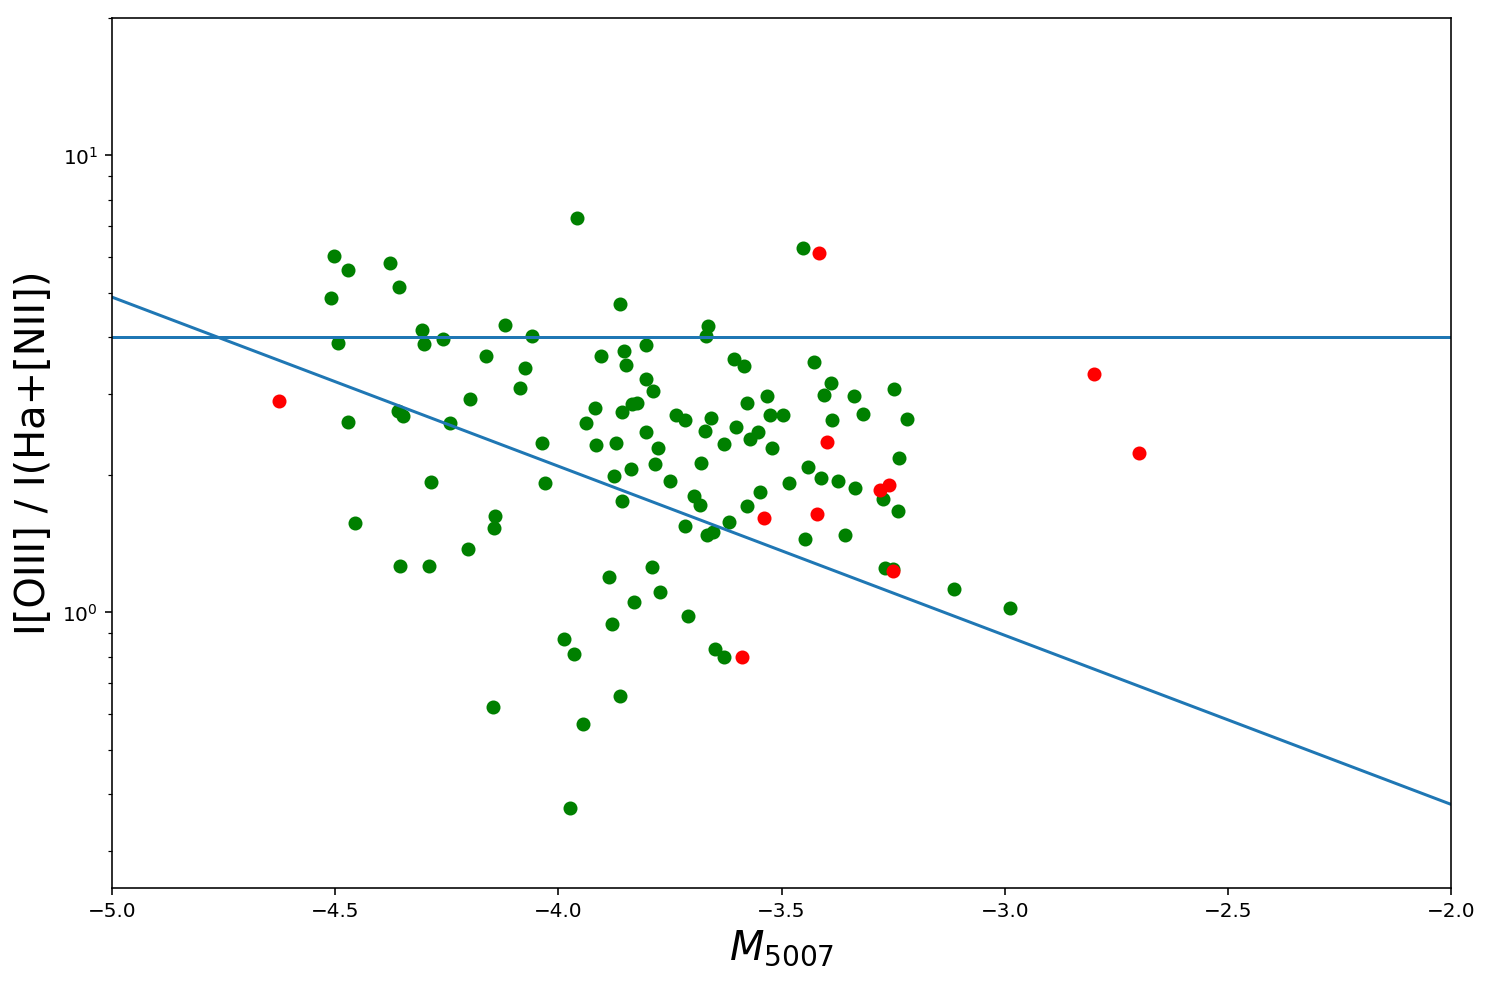

In [15]:
em_ratios = np.load("exported_data/FCC167/gandalf/emission_ratios.npy")
OIII_by_Ha, OIII_by_Ha_plus_NII, NII_by_Ha, OIII_by_SII = em_ratios

PNe_df["OIII/Ha"] = OIII_by_Ha
PNe_df["OIII/Ha+NII"] = OIII_by_Ha_plus_NII
PNe_df["NII/Ha"] = NII_by_Ha
PNe_df["OIII/SII"] = OIII_by_SII

plt.figure(figsize=(12,8))
plt.yscale("log")
plt.scatter(PNe_df["M 5007"].loc[PNe_df["Filter"]=="Y"], OIII_by_Ha_plus_NII[y_idx], c="g")
plt.scatter(PNe_df["M 5007"].loc[PNe_df["Filter"]=="N"], OIII_by_Ha_plus_NII[n_idx], c="r")

plt.axhline(4)
plt.ylim(0.25,20)
plt.xlim(-5,-2)
x = np.arange(-5, -2,0.001)
plt.plot(x, 10**((-0.37 * x) - 1.16))
plt.ylabel("I[OIII] / I(Ha+[NII])", fontsize="20")
plt.xlabel("$M_{5007}$", fontsize="20")
# plt.savefig("Plots/FCC167/[OIII]Ha+NII.png")

# LOSV work

In [126]:
v_star, s_star = hdulist_ppxf[1].data.V, hdulist_ppxf[1].data.SIGMA
np.median(v_star)

1819.441952596254

In [131]:
5006.77*(1+z)

5039.052621366012

In [51]:
v_star, s_star = hdulist_ppxf[1].data.V, hdulist_ppxf[1].data.SIGMA
np.median(v_star)

1819.441952596254

In [54]:
## Velocity from files
hdulist_ppxf = fits.open(RAW_DIR+f"/{galaxy_name}center_ppxf_SPAXELS.fits")
v_star, s_star = hdulist_ppxf[1].data.V, hdulist_ppxf[1].data.SIGMA

# LOS_z = (np.median(v_star) * 1e3) / c
LOS_z = (np.median(v_star) * 1e3) / c

LOS_de_z = np.array(mean_wave_list[:,0] / (1 + LOS_z))
    
PNe_df["PNe_LOS_V"] = (c * (LOS_de_z - 5006.77) / 5006.77) / 1000. 

hdulist_table = fits.open(RAW_DIR+f"/{galaxy_name}center_table.fits")
X_star, Y_star = hdulist_table[1].data.XBIN, hdulist_table[1].data.YBIN
flux_star = hdulist_table[1].data.FLUX

idx = flux_star.argmax()
X_star, Y_star = X_star-X_star[idx], Y_star-Y_star[idx]

cond = np.sqrt( (X_star)**2 + (Y_star)**2 ) <= 5.0
vsys = np.median(v_star[cond])
v_star = v_star-vsys

f_ind = PNe_df.loc[PNe_df["Filter"]=="Y"].index
# f_ind = PNe_df.index

gal_centre_pix = Table.read("exported_data/galaxy_centre_pix.dat", format="ascii")

gal_ind = np.where(gal_centre_pix["Galaxy"]==galaxy_name)
gal_x_c = gal_centre_pix["x_pix"][gal_ind]
gal_y_c = gal_centre_pix["y_pix"][gal_ind]

xpne, ypne = (x_PNe[f_ind]-gal_x_c)*0.2, (y_PNe[f_ind]-gal_y_c)*0.2

# Estimating the velocity dispersion of the PNe along the LoS
def sig_PNe(X_star,Y_star,v_stars,sigma,x_PNe,y_PNe,vel_PNe):

    d_PNe_to_skin = np.zeros(len(x_PNe))
    Vs_PNe = np.ones(len(x_PNe)) # Velocity of the closest star
    Ss_PNe = np.ones(len(x_PNe)) # Sigma for each PNe
    i_skin_PNe = []

    """ To estimate the velocity dispersion for PNe we need to
    extract the sigma of the closest stars for each PNe """

    for i in range(len(x_PNe)):
        r_tmp = np.sqrt((X_star-x_PNe[i])**2+(Y_star-y_PNe[i])**2)
        d_PNe_to_skin[i] = min(r_tmp)
        i_skin_PNe.append(r_tmp.argmin())

    Vs_PNe  = v_stars[i_skin_PNe]
    Ss_PNe  = sigma[i_skin_PNe]
    rad_PNe = np.sqrt(x_PNe**2+y_PNe**2)
    k = np.where(d_PNe_to_skin > 1.0)

    return rad_PNe, (vel_PNe-Vs_PNe)/Ss_PNe, k

rad_PNe, vel_ratio, k  = sig_PNe(X_star, Y_star, v_star, s_star, xpne, ypne, PNe_df["PNe_LOS_V"].loc[PNe_df["Filter"]=="Y"])
# rad_PNe, vel_ratio, k  = sig_PNe(X_star, Y_star, v_star, s_star, xpne, ypne, PNe_df["PNe_LOS_V"])


# Scatter points for measured PNe velocity

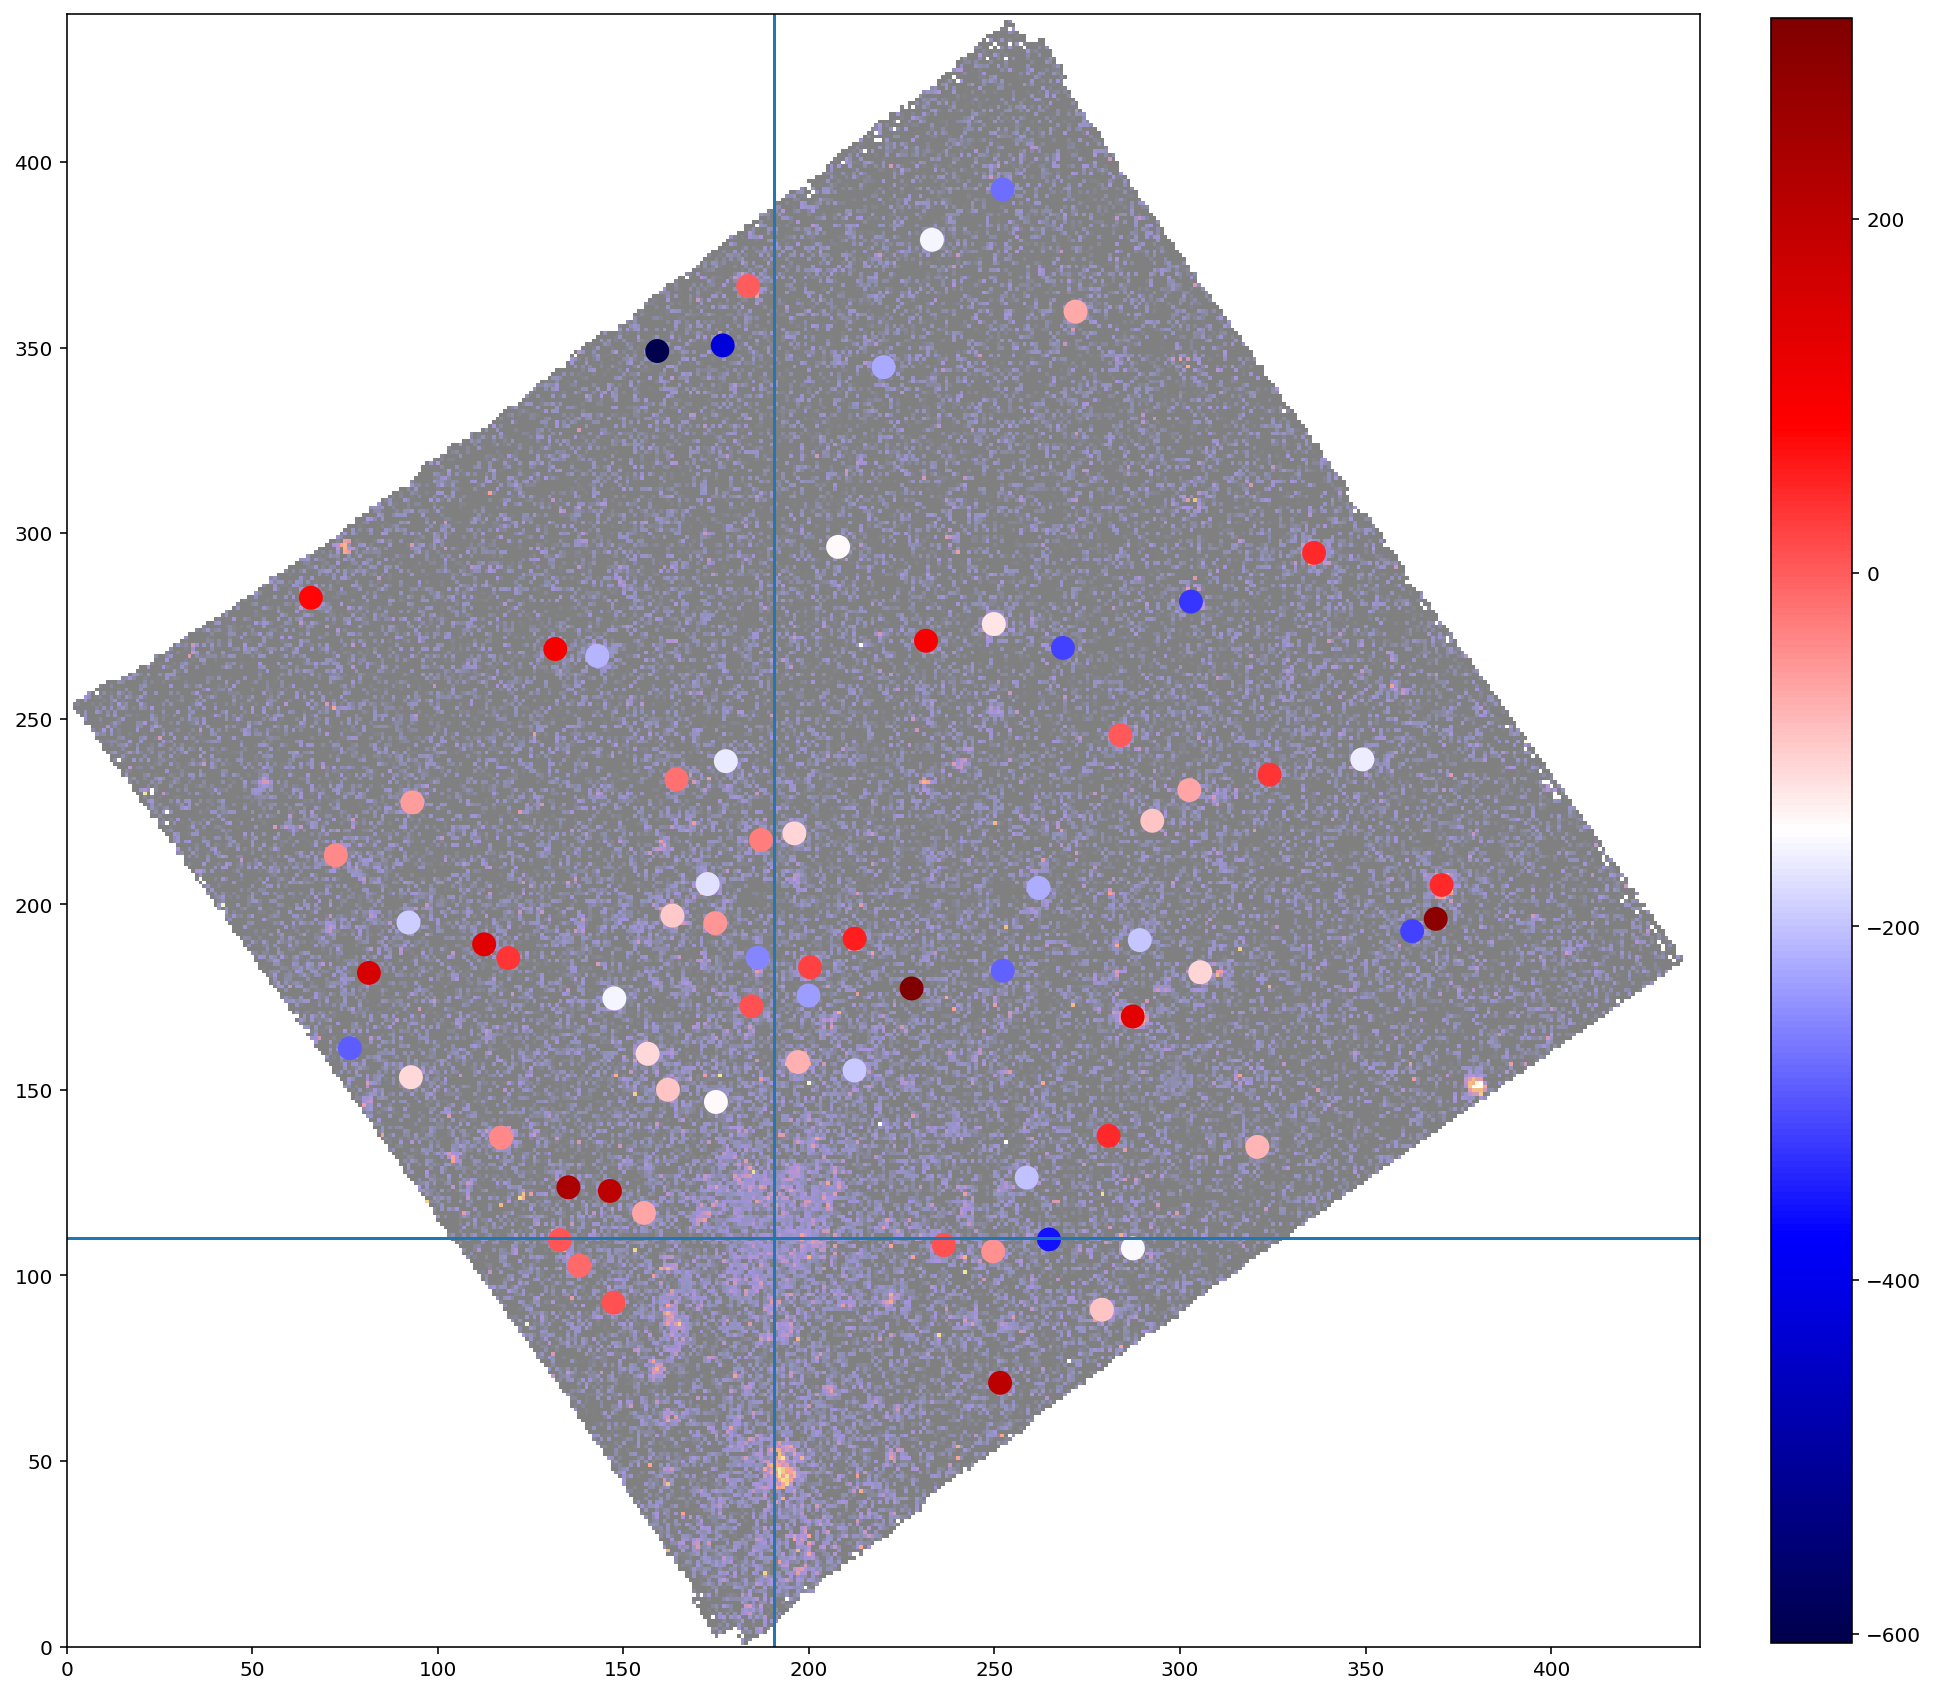

In [47]:
# Scatter plot the x y locations of PNe, colour coding them with their velocity
# ind=PNe_df.loc[PNe_df["Filter"]=="Y"].index
ind=PNe_df.loc[(PNe_df["Filter"]=="Y")].index


positions = (x_PNe[ind], y_PNe[ind])
apertures = CircularAperture(positions, r=4)
plt.figure(figsize=(16,16))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=8., alpha=0.5)
plt.scatter(x_PNe[ind], y_PNe[ind], c=PNe_df["V (km/s)"].loc[PNe_df["Filter"]=="Y"], cmap="seismic", s=120)
# plt.scatter(x_PNe, y_PNe, c=PNe_df["m 5007"], cmap="inferno_r", s=120)
if galaxy_name=="FCC219":
    plt.ylim(0,440)
    plt.xlim(0,440)
elif galaxy_name=="FCC193":
    plt.ylim(250,)
    plt.xlim(0,350)
elif galaxy_name == "FCC276":
    plt.xlim(310,)
cb = plt.colorbar(fraction=0.0455, pad=0.04)
# cb.set_label("$V_{[OIII]} \ (km \ s^{-1}$)", fontsize=20)
#plt.savefig(PLOT_DIR"PNe_velocity_dist_map.pdf")

plt.axhline(gal_y_c)
plt.axvline(gal_x_c)

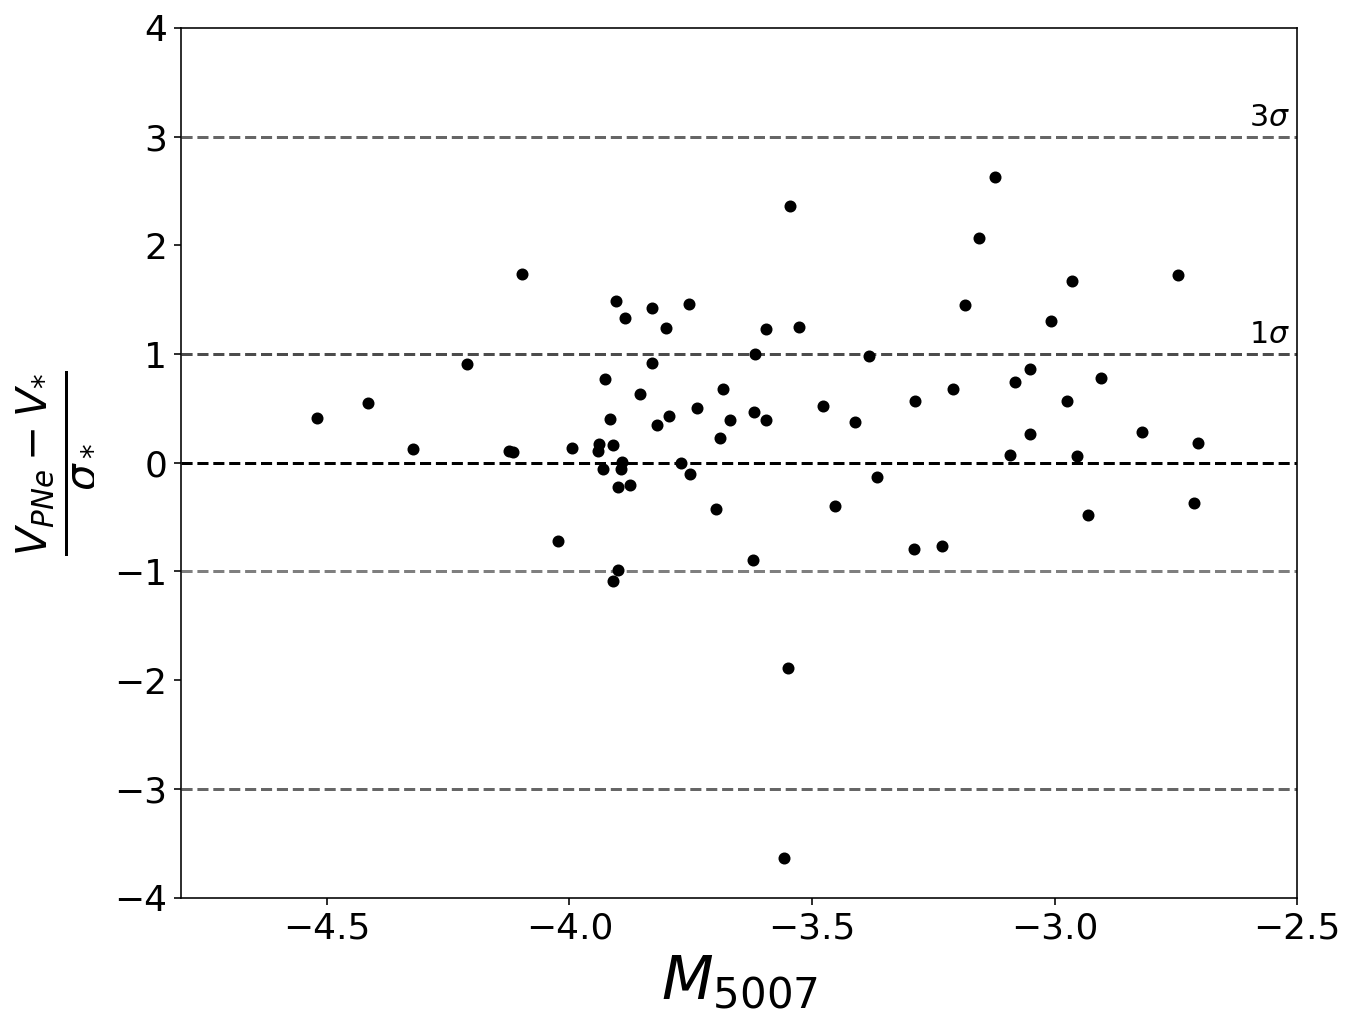

In [48]:
plt.figure(44, figsize=(10,8))
plt.clf()
plt.scatter(PNe_df["M 5007"].loc[PNe_df["Filter"]=="Y"], vel_ratio, s=25, c="k")
# plt.scatter(PNe_df["M 5007"], vel_ratio, s=25, c="k")
plt.xlabel("$M_{5007}$", fontsize=30)
plt.ylabel(r"$\frac{V_{PNe} - V_{*}}{\sigma_*}$", fontsize=30, labelpad=10)
plt.axhline(y=1, c="k", ls="dashed", alpha=0.7)
plt.axhline(y=3, c="k", ls="dashed", alpha=0.6)
plt.axhline(y=0, c="k", ls="dashed")
plt.axhline(y=-3, c="k", ls="dashed", alpha=0.6)
plt.axhline(y=-1, c="k", ls="dashed", alpha=0.5)
plt.annotate(r"1$\sigma$", xy=(-2.6,1.1), fontsize=15)
plt.annotate(r"3$\sigma$", xy=(-2.6,3.1), fontsize=15)
plt.ylim(-4,4)
plt.xlim(-4.8,-2.5)
plt.tick_params(labelsize = 18)
# plt.savefig(PLOT_DIR+"_velocity_scatter_plot.pdf", bbox_inches='tight')

In [44]:
norm.fit(vel_ratio[f_ind])

(-0.546276249404707, 0.8452088325886081)

(-3.25, 3.25)

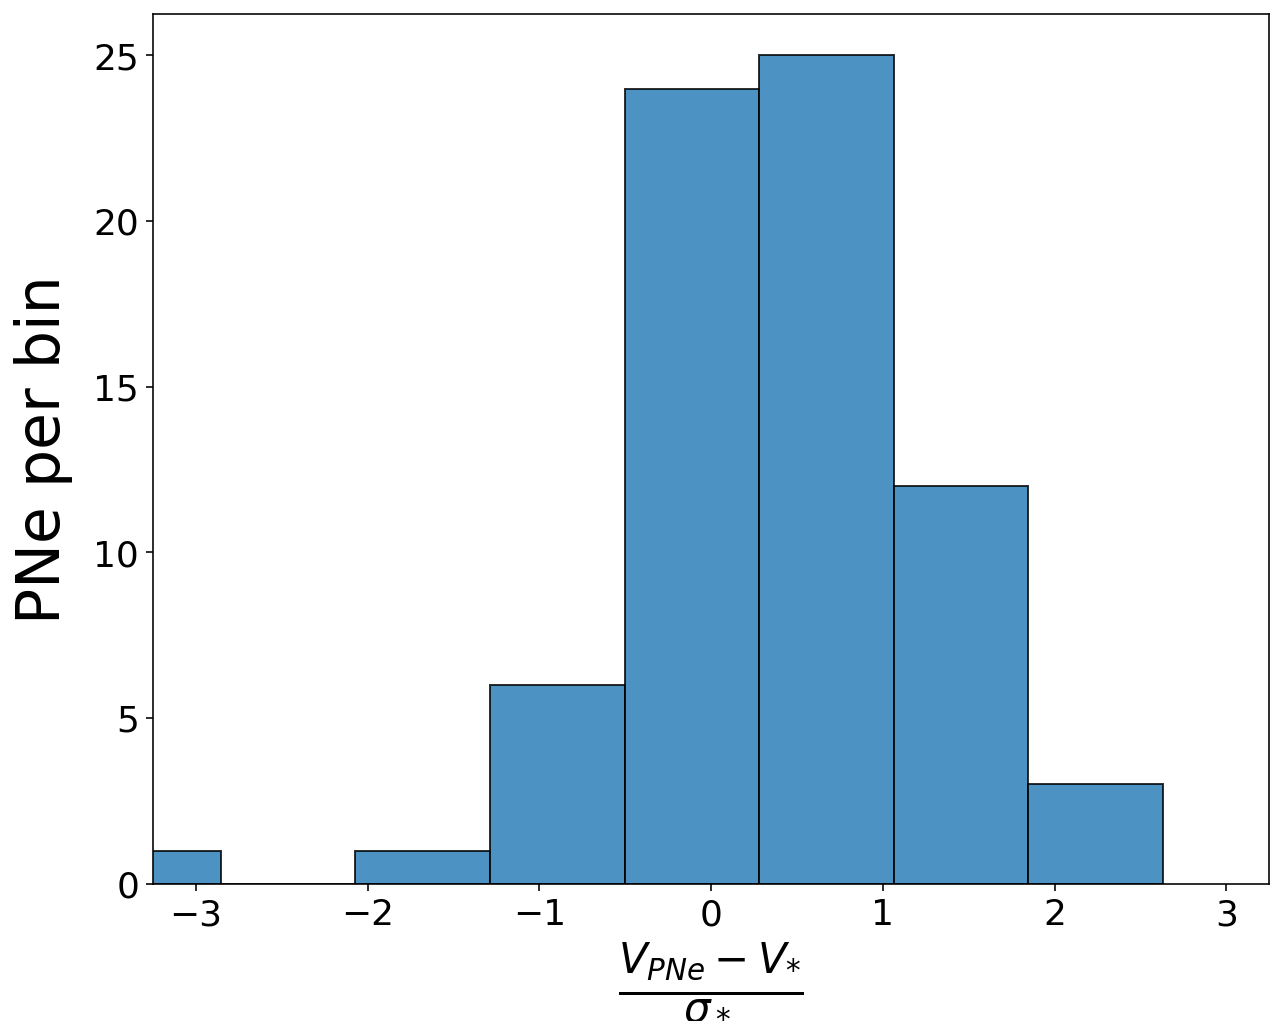

In [55]:
plt.figure(44, figsize=(10,8))
plt.clf()
plt.hist(vel_ratio[f_ind], bins=8, edgecolor="k", alpha=0.8, linewidth=1)
fit = stats.norm.pdf(vel_ratio[f_ind], np.mean(vel_ratio[f_ind]), np.std(vel_ratio[f_ind]))
#plt.plot(vel_ratio[f_ind],fit, "o")
plt.xlabel(r"$\frac{V_{PNe} - V_{*}}{\sigma_*}$", fontsize=30)
plt.ylabel("PNe per bin", fontsize=30, labelpad=10)
plt.tick_params(labelsize = 18)
plt.xlim(-3.25,3.25)
#plt.ylim(0,50)
# plt.savefig(PLOT_DIR+"_velocity_bins_plot.pdf", bbox_inches='tight')

#plt.figure()
#sns.distplot(vel_ratio[f_ind], hist=True, fit=stats.norm, kde=True, bins=10,
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 2})

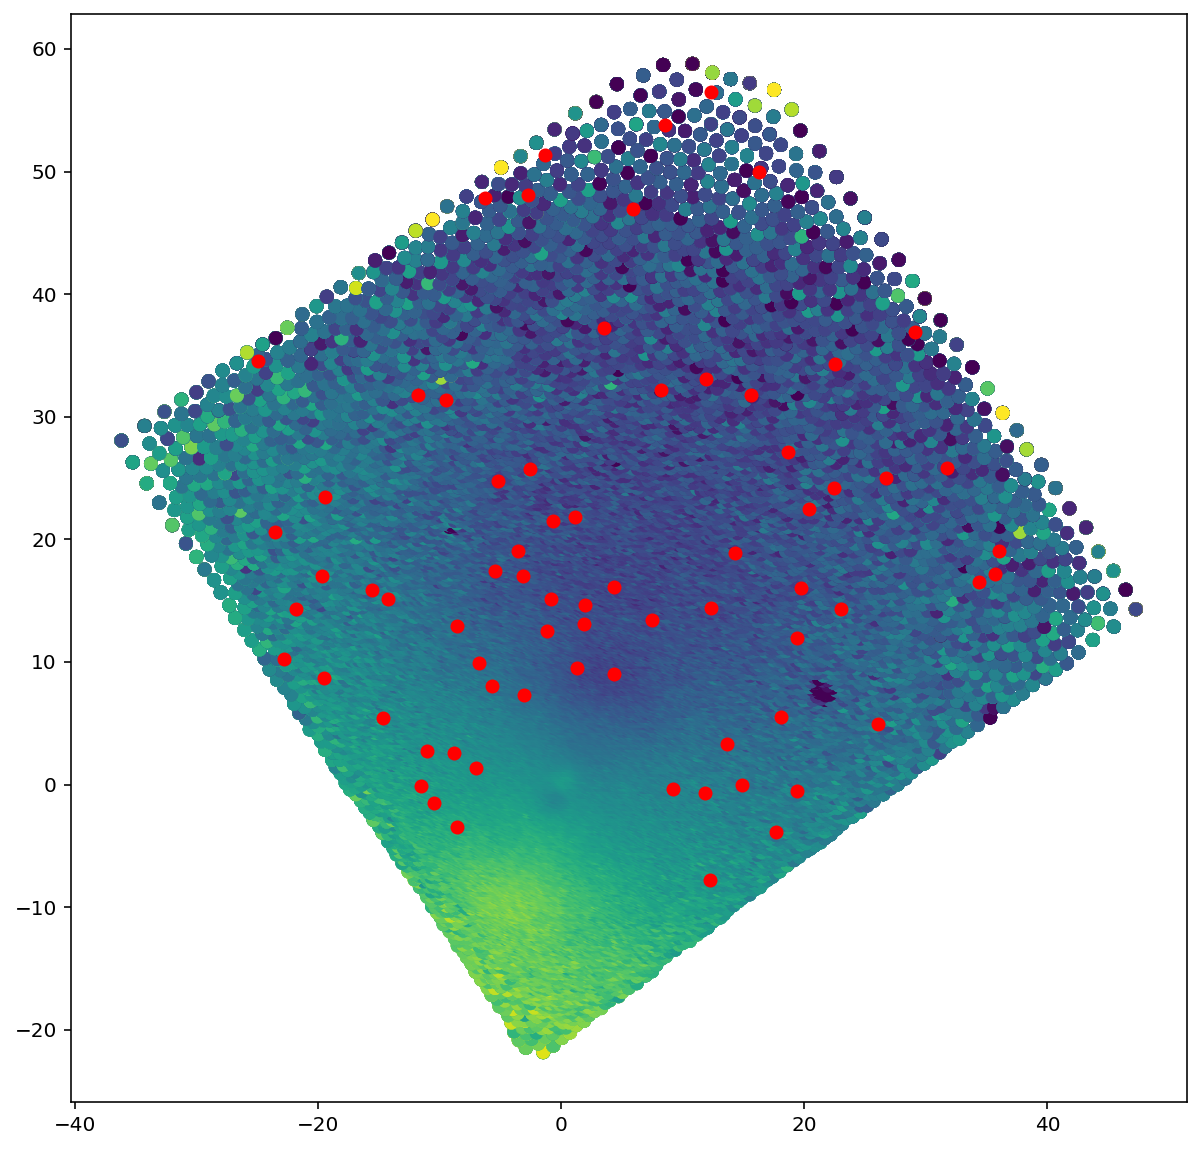

In [57]:
plt.figure(figsize=(10,10))
plt.scatter(X_star, Y_star, c=v_star, vmin=-150, vmax=150)
plt.scatter(xpne,ypne,c="r")
#plt.colorbar()

## Table setup for Marc

In [17]:
## Tables for Marc
y_idx = PNe_df.loc[PNe_df["Filter"]=="Y"].index.values
n_idx = PNe_df.loc[PNe_df["Filter"]=="N"].index.values

tab_all = Table([PNe_df["PNe number"].values, 
                 PNe_df["A/rN"].values, 
                 PNe_df["Chi2"].values, 
                 A_2D_list[:,0], x_PNe, y_PNe, objects["peak"], mean_wave_list[:,0]], 
                names=("PNe #","fit A/rN", "Chi2", "A", "x", "y", "SEP A/rN", "best_fit_wave"))

tab_filter = Table([PNe_df["PNe number"].loc[PNe_df["Filter"]=="Y"], 
                    PNe_df["A/rN"].loc[PNe_df["Filter"]=="Y"].values, 
                    PNe_df["Chi2"].loc[PNe_df["Filter"]=="Y"].values, A_2D_list[y_idx,0], x_PNe[y_idx], y_PNe[y_idx], 
                    objects["peak"][y_idx], mean_wave_list[y_idx,0]], 
                   names=("PNe #","fit A/rN", "Chi2", "A", "x", "y", "SEP A/rN", "best_fit_wave"))

ascii.write(tab_all, EXPORT_DIR+galaxy_name+"_SEP_all_data_Table.dat", overwrite=True)
ascii.write(tab_filter, EXPORT_DIR+galaxy_name+"_SEP_filtered_data_Table.dat", overwrite=True)

# PSF determination

[35, 49, 23]
FWHM:  3.653546247967806 +/- 0.10434341600522187 (2.86%)
Beta:  1.8458890865284971 +/- 0.21779989795046614 (11.80%)
LSF:  3.287680007588589 +/- 0.05627564633692093 (1.71%)




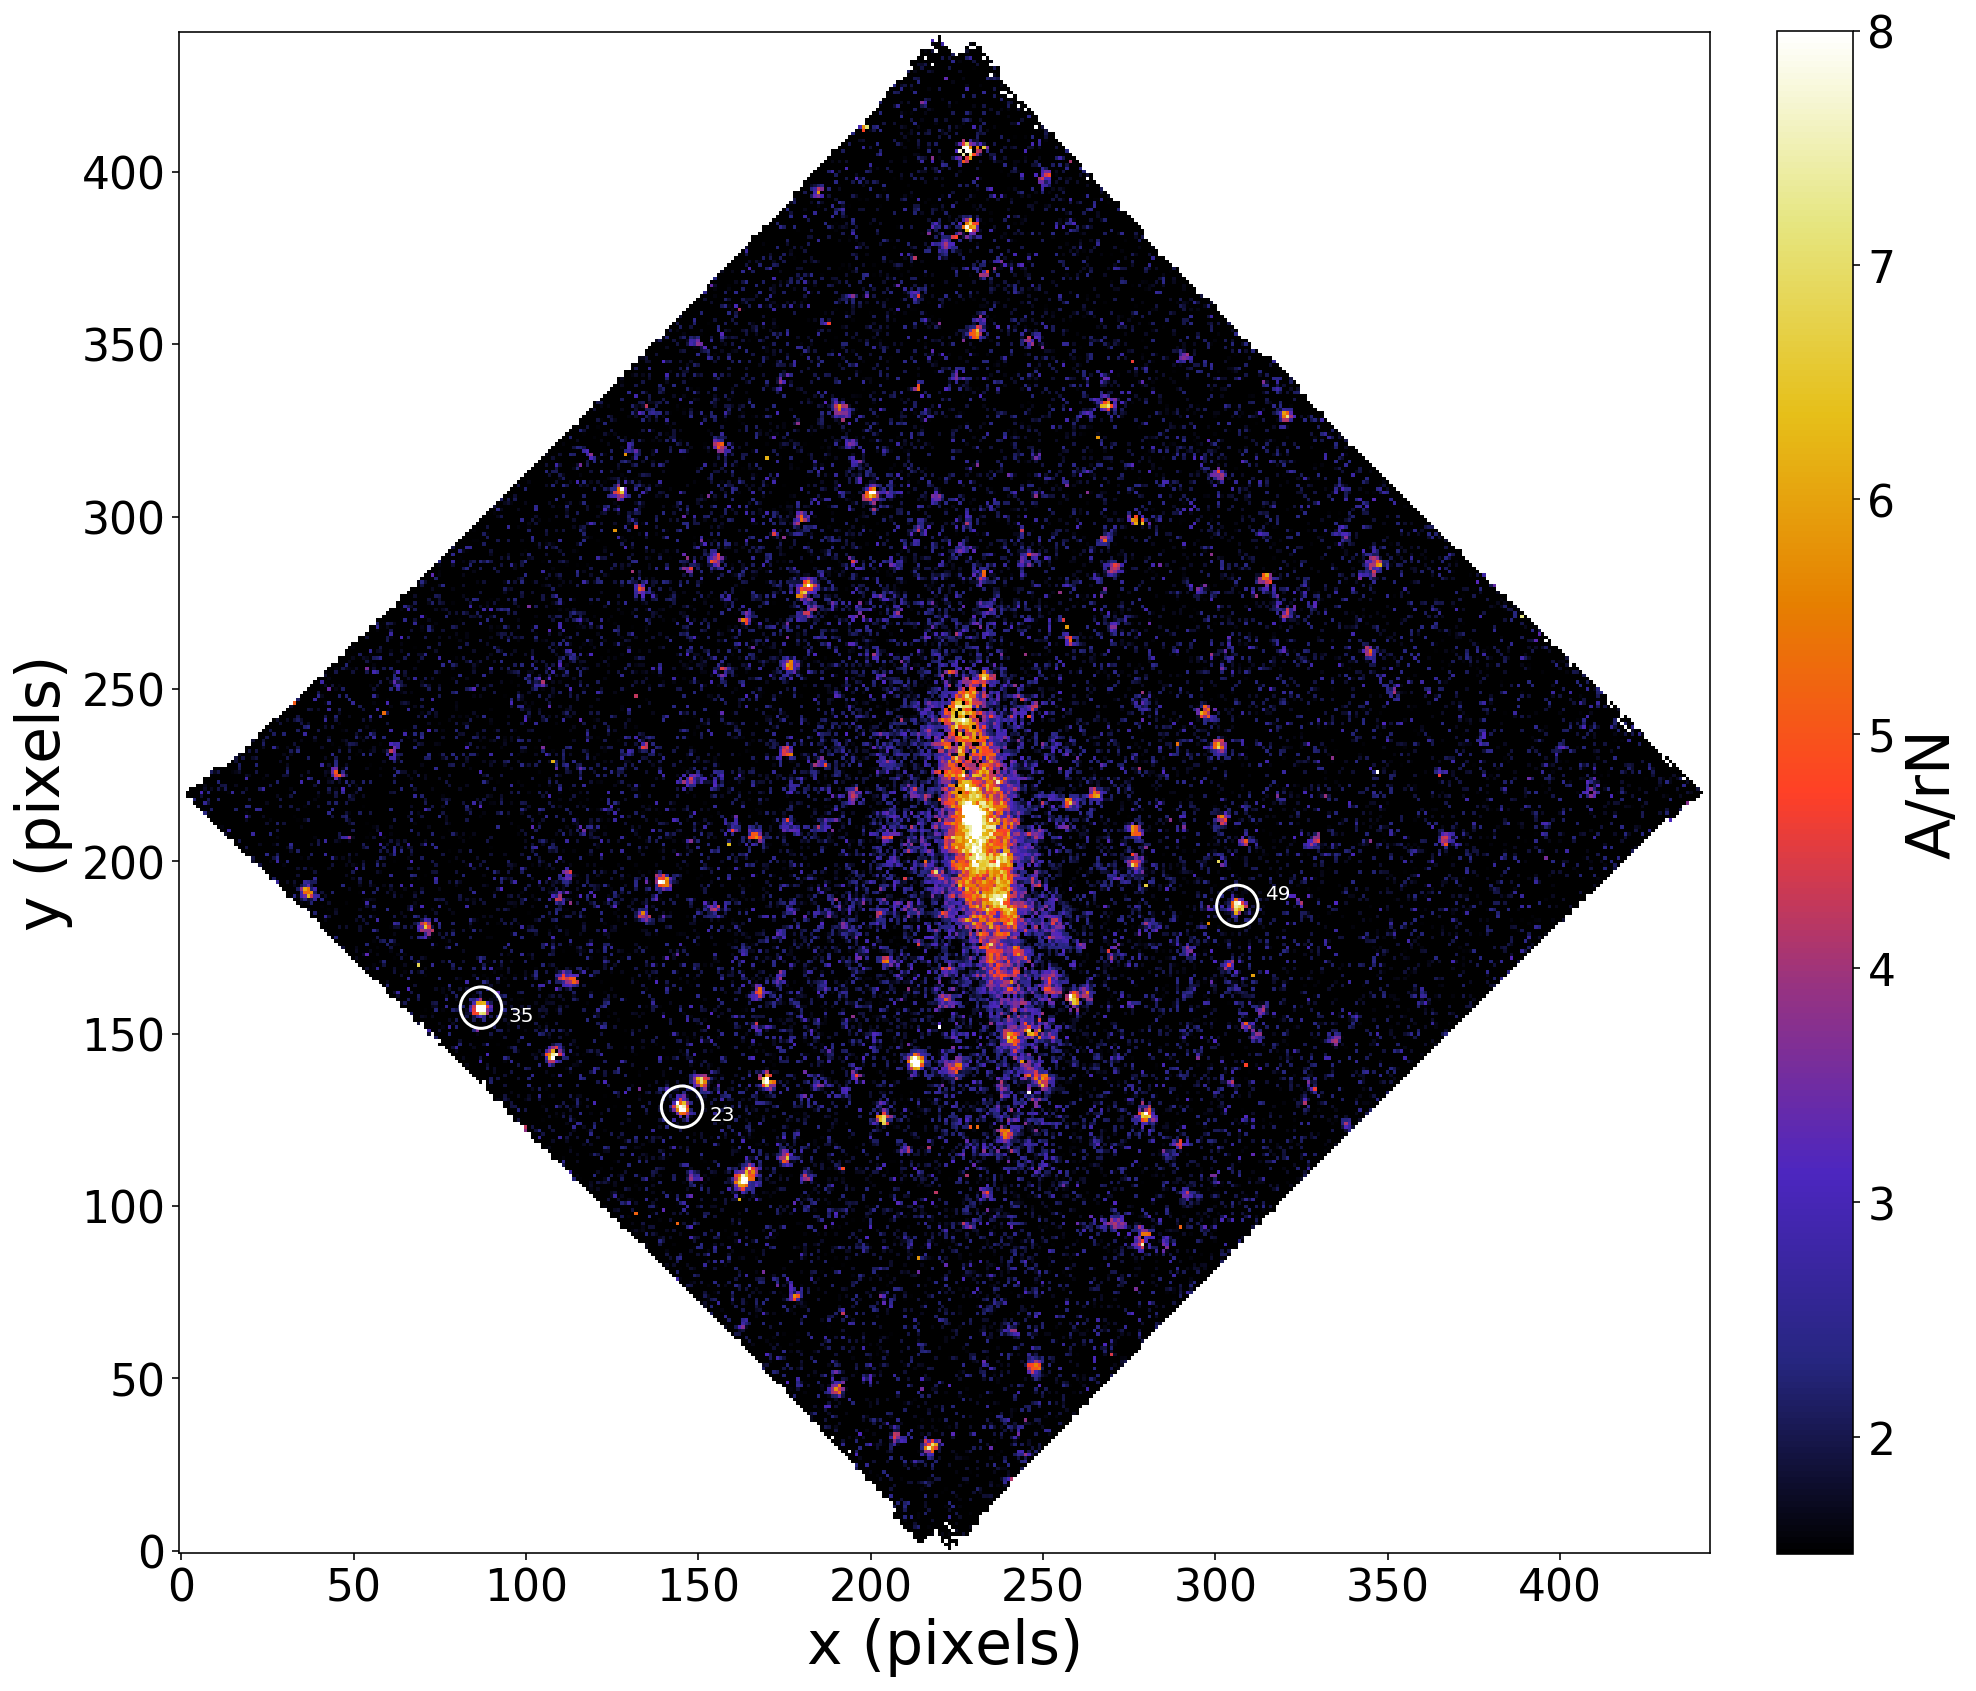

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 129
    # data points      = 45198
    # variables        = 15
    chi-square         = 2851173.44
    reduced chi-square = 63.1027917
    Akaike info crit   = 187350.086
    Bayesian info crit = 187480.869
[[Variables]]
    moffat_amp_000:  263.610273 +/- 8.50331106 (3.23%) (init = 200)
    x_000:           3.52496002 +/- 0.05747808 (1.63%) (init = 4.5)
    y_000:           4.04778258 +/- 0.05763842 (1.42%) (init = 4.5)
    wave_000:        5037.93701 +/- 0.04307167 (0.00%) (init = 5038.134)
    gauss_bkg_000:   0 (fixed)
    gauss_grad_000:  0 (fixed)
    moffat_amp_001:  295.869941 +/- 9.14474685 (3.09%) (init = 200)
    x_001:           4.02958874 +/- 0.05098184 (1.27%) (init = 4.5)
    y_001:           4.51533316 +/- 0.05110064 (1.13%) (init = 4.5)
    wave_001:        5035.72627 +/- 0.03841439 (0.00%) (init = 5038.134)
    gauss_bkg_001:   0 (fixed)
    gauss_grad_001:  0 (fixed)
    moffat_amp_002:  260

In [21]:
### Single Run PSF Fitter
#sel_PNe = PNe_df.nsmallest(4, "m 5007").index.values
if galaxy_name == "FCC083":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[(PNe_df["PNe number"] != 40) & (PNe_df["PNe number"] != 60)].nlargest(5, "A/rN").index.values#.loc[PNe_df["PNe number"] != 38].
elif galaxy_name == "FCC119":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(1, "A/rN").index.values
elif galaxy_name == "FCC143":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(1, "A/rN").index.values
elif galaxy_name == "FCC147":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[(PNe_df["PNe number"] != 42)&(PNe_df["PNe number"] != 4)].nlargest(3, "A/rN").index.values
    #sel_PNe = [43,64,19,12,6]
elif galaxy_name == "FCC161":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(7, "A/rN").index.values#.loc[PNe_df["PNe number"] != 38].
elif galaxy_name == "FCC167":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] != 129].nlargest(5, "A/rN").index.values
elif galaxy_name == "FCC177":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(4, "A/rN").index.values
elif galaxy_name == "FCC182":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] !=9].nlargest(3, "A/rN").index.values
    sel_PNe = [6,0,8]
elif galaxy_name == "FCC184":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] !=29].nlargest(3, "A/rN").index.values
#     sel_PNe = [ 8, 71, 67]
elif galaxy_name == "FCC190":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(7, "A/rN").index.values
elif galaxy_name == "FCC193":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] != 94].nlargest(6, "A/rN").index.values
elif galaxy_name == "FCC219":
    sel_PNe = [58]#PNe_df.loc[PNe_df["Filter"]=="Y"].loc[(PNe_df["PNe number"] != 48) & (PNe_df["PNe number"] != 26)].nlargest(5, "A/rN").index.values
elif galaxy_name == "FCC249":
#     sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(2, "A/rN").index.values
    sel_PNe = [1,19,3]
elif galaxy_name == "FCC255":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(5, "A/rN").index.values
elif galaxy_name == "FCC276":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(6, "A/rN").index.values#.loc[PNe_df["PNe number"] != 21]
elif galaxy_name == "FCC277":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(5, "A/rN").index.values
elif galaxy_name == "FCC301":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] != 15].nlargest(5, "A/rN").index.values
elif galaxy_name == "FCC310":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[(PNe_df["PNe number"] != 42)].nlargest(7, "A/rN").index.values

#sel_PNe = PNe_df.loc[PNe_df["PNe number"] != 1].nlargest(10, "A/rN").index.values

sel_PNe = [35,49,23]#[ 35,  126,  49]
print(sel_PNe)

selected_PNe = PNe_spectra[sel_PNe]
selected_PNe_err = obj_error_cube[sel_PNe]
PSF_params = Parameters()

def model_params(p, n, amp, mean):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.01)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.1, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.1, max=n_pixels)
    PSF_params.add("wave_{:03d}".format(n), value=mean, min=mean-15., max=mean+15.)
    PSF_params.add("gauss_bkg_{:03d}".format(n),  value=0.000, vary=False)
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.000, vary=False)


for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=200.0, mean=5006.77*(1+z))    
    
PSF_params.add('FWHM', value=4.0,  min=0.01, vary=True)
PSF_params.add("beta", value=2.5,  min=0.01, vary=True) 
PSF_params.add("LSF",  value=2.81,)# min=0.01, vary=True)

PSF_results = minimize(PSF_residuals_3D, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err, z), nan_policy="propagate")

print("FWHM: ", PSF_results.params["FWHM"].value, "+/-", PSF_results.params["FWHM"].stderr, "({:3.2f}%)".format((PSF_results.params["FWHM"].stderr / PSF_results.params["FWHM"].value)*100) )
print("Beta: ", PSF_results.params["beta"].value, "+/-", PSF_results.params["beta"].stderr, "({:3.2f}%)".format((PSF_results.params["beta"].stderr / PSF_results.params["beta"].value)*100) )
print("LSF: " , PSF_results.params["LSF"].value , "+/-", PSF_results.params["LSF"].stderr,  "({:3.2f}%)".format((PSF_results.params["LSF"].stderr  / PSF_results.params["LSF"].value)*100)  )
print("\n")

# Plot locations of PNe used for PSF
plt.figure(figsize=(15,15))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap",  vmin=1.5, vmax=8)
ax = plt.gca()
cb=plt.colorbar(fraction=0.0455, pad=0.04)
cb.set_label("A/rN",fontsize=30)
cb.ax.tick_params(labelsize=22)

plt.xlabel("x (pixels)", fontsize=30)
plt.ylabel("y (pixels)", fontsize=30)

plt.tick_params(labelsize = 22)

#plt.xlim(0,450)
#plt.ylim(0,450)

for (i, item), n in zip(enumerate(x_y_list[sel_PNe]), sel_PNe):
    ax = plt.gca()
    circ = plt.Circle((item[0],item[1]),6, color="white",lw=1.5, fill=False)
    ax.add_artist(circ)
    if item[0]<240.:
        ax.annotate(n, (item[0]+8, item[1]-4), color="white", size=10)
    else:
        ax.annotate(n, (item[0]+8, item[1]+2), color="white", size=10)

plt.show()
print(report_fit(PSF_results, show_correl=False))


# PNLF

/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/MUSE_Models.py:119: RuntimeWarning: invalid value encountered in true_divide
  u2 = (d/(9.0*mad))**2  # c = 9
/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/MUSE_Models.py:120: RuntimeWarning: invalid value encountered in less
  good = u2 < 1.0
/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/MUSE_Models.py:124: RuntimeWarning: invalid value encountered in double_scalars
  sigma = np.sqrt(num/(den*(den - 1.0)))  # see note in above reference
/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/PNLF.py:65: RuntimeWarning: invalid value encountered in less
  image[image<0] = 0
/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/PNLF.py:121: RuntimeWarning: divide by zero encountered in true_divide
  ratio_counter_cen[i] = (np.nansum(image[((a / Noise_mask_cen) > peak)])/np.nansum(image)).astype(np.float128)
/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/PNLF.py:121: RuntimeWarning: i

Number of PNe from PNLF:  174.1766681906035 +/- 20.526917200342496


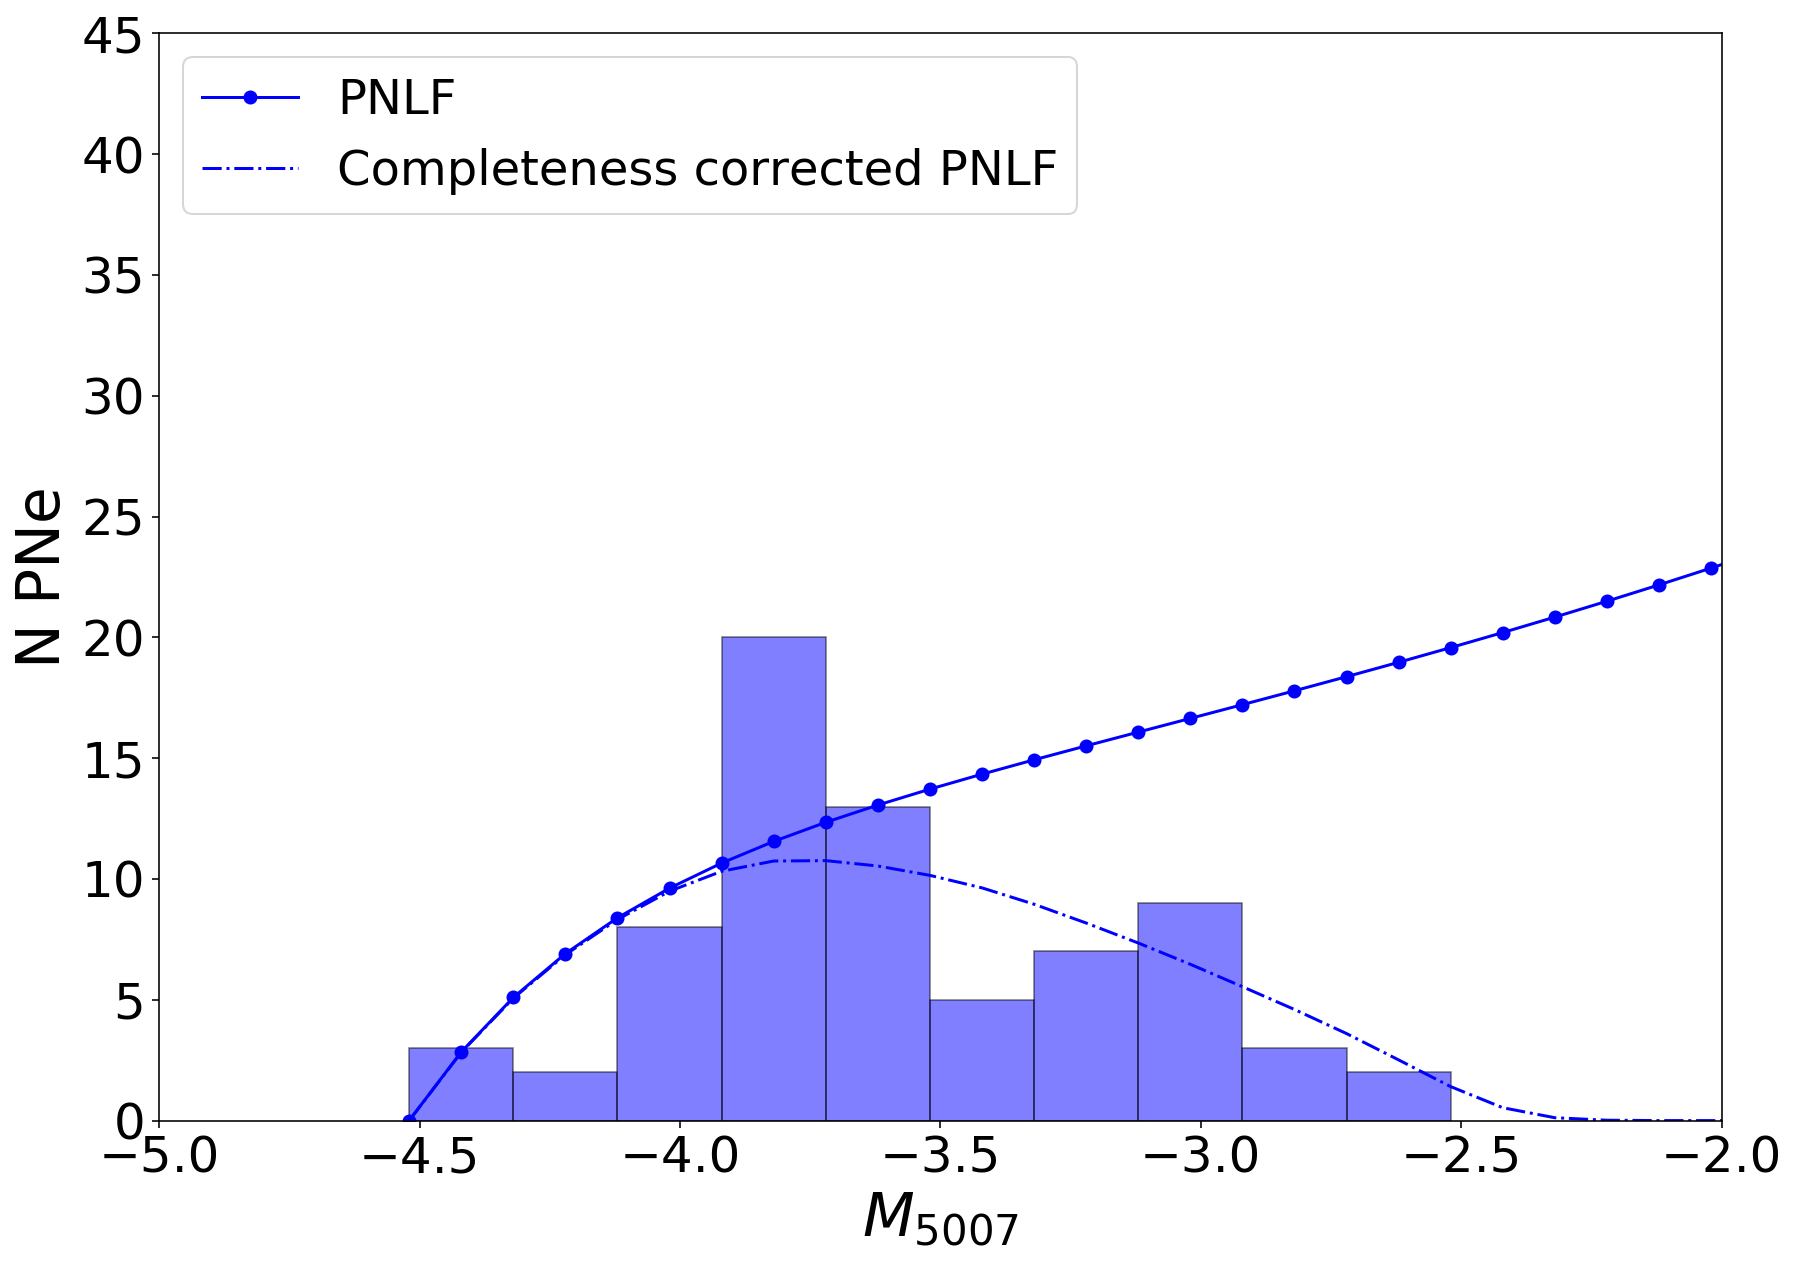

In [31]:
x_data_cen, y_data_cen, map_cen, aux = open_data(galaxy_name)

image, wave = reconstructed_image(galaxy_name)
image = image.reshape([y_data_cen,x_data_cen])

# mag = PNe_df["M 5007"].loc[PNe_df["Filter"]=="Y"].values
mag = PNe_df["M 5007"].loc[PNe_df["Filter"]=="Y"].values

# Total PNLF
PNLF, PNLF_corr, Abs_M = completeness(galaxy_name, mag, PNe_multi_params, Dist_est, image, peak=3.0,
                                      gal_mask_params=gal_mask_params, star_mask_params=star_mask_params, 
                                      c1=0.307, z=z ) # Estimating the completeness for the central pointing # Dist_est



# Getting the normalisation
total_norm = np.sum(np.abs(PNLF_corr))*abs(Abs_M[1]-Abs_M[0])

# Scaling factor
scal = len(mag)/total_norm

# Constraining to -2.0 in magnitude
idx = np.where(Abs_M <= np.min(mag)+2.0)
# Total number of PNe
tot_N_PNe = np.sum(PNLF_corr[idx]*scal)*abs(Abs_M[1]-Abs_M[0])


plt.figure(figsize=(14,10))
#plt.figure(figsize=(12,10))
binwidth = 0.2
hist = plt.hist(mag, bins=np.arange(min(mag), max(mag) + binwidth, binwidth), edgecolor="black", linewidth=0.8, alpha=0.5, color='blue')

ymax = max(hist[0])

plt.plot(Abs_M, PNLF*scal*binwidth, '-', color='blue', marker="o", label="PNLF")
plt.plot(Abs_M, PNLF_corr*scal*binwidth,'-.', color='blue', label="Completeness corrected PNLF")

plt.xlabel('$M_{5007}$', fontsize=30)
plt.ylabel('N PNe', fontsize=30)
#plt.yticks(np.arange(0,ymax+4, 5))

plt.xlim(-5.0,-2.0); plt.ylim(0,45);
#plt.xlim(26.0,30.0); plt.ylim(0,45);

plt.tick_params(labelsize = 25)

#plt.axvline(PNe_df["m 5007"].loc[PNe_df["Filter"]=="Y"].values.min() - 31.63)
plt.legend(loc=2, fontsize=24)
#plt.savefig(PLOT_DIR"_PNLF.pdf", bbox_inches='tight')
#plt.savefig(PLOT_DIR"_PNLF.png", bbox_inches='tight')

step = Abs_M[1]-Abs_M[0]
N_PNe = np.sum(PNLF[:25]*scal*step)
print("Number of PNe from PNLF: ", N_PNe, "+/-", (1/np.sqrt(len(PNe_df.loc[PNe_df["Filter"]=="Y"])))*N_PNe)

## L_Bol using pPXF

In [94]:
PNe_df.loc[15]

PNe number                      15
Ra (J2000)                     NaN
Dec (J2000)                    NaN
V (km/s)                  0.288553
m 5007                     26.7287
M 5007                       -4.52
[OIII] Flux              6.494e-17
M 5007 error                   NaN
A/rN                       10.9901
rad D                          NaN
redchi                     1.00797
Filter                           Y
Chi2                       23099.7
Flux error             2.36268e-18
m 5007 error             0.0394588
F[OIII] err percent        3.63826
Name: 15, dtype: object

100%|██████████| 95985/95985 [00:16<00:00, 5923.44it/s]


Collapsing cube now....
Cube has been collapsed...


/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/ppxf_gal_L.py:149: RuntimeWarning: divide by zero encountered in true_divide
  templates[:, j] = sspNew/np.median(sspNew)  # Normalizes templates
/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/ppxf_gal_L.py:149: RuntimeWarning: invalid value encountered in true_divide
  templates[:, j] = sspNew/np.median(sspNew)  # Normalizes templates


Best Fit:       Vel     sigma        h3        h4
 comp. 0:       490       204    -0.008    -0.004
chi2/DOF: 3.007
method = capfit; Jac calls: 18; Func calls: 367; Status: 2
Nonzero Templates: 3 / 636
Formal errors:
     dV    dsigma   dh3      dh4
 2.5e+02 3.2e+02    0.85    0.57
Elapsed time in PPXF: 487.41 s
24247540796.246853


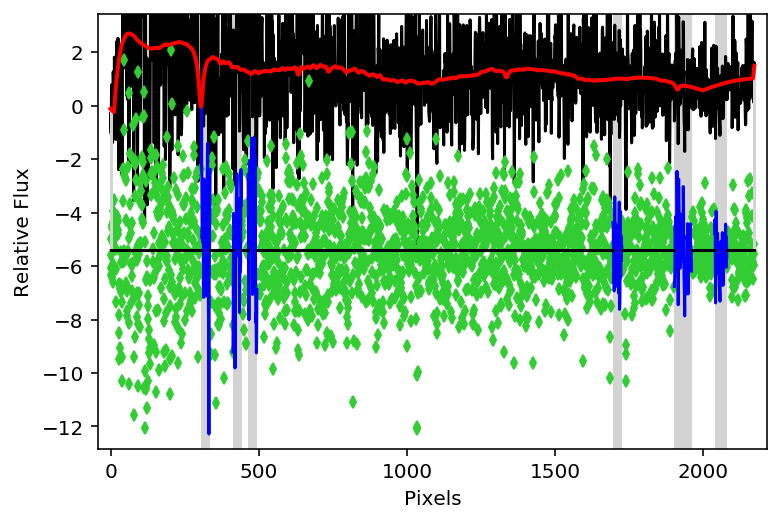

In [8]:

raw_data_cube = RAW_DIR+"center.fits" # read in raw data cube

xe, ye, length, width, alpha = gal_mask_params

orig_hdulist = fits.open(raw_data_cube)
raw_data_cube = np.copy(orig_hdulist[1].data)
h1 = orig_hdulist[1].header
s = np.shape(orig_hdulist[1].data)
Y, X = np.mgrid[:s[1], :s[2]]
elip_mask = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (width/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2)) ** 2 <= 1    

# Now mask the stars
star_mask_sum = np.sum([(Y - yc)**2 + (X - xc)**2 <= rc**2 for xc,yc,rc in star_mask_params],0).astype(bool)
    
    
total_mask = ((np.isnan(orig_hdulist[1].data[1,:,:])==False) & (elip_mask==False) & (star_mask_sum==False))
indx_mask = np.where(total_mask==True)

good_spectra = np.zeros((s[0], len(indx_mask[0])))

for i, (y, x)  in enumerate(zip(tqdm(indx_mask[0]), indx_mask[1])):
    good_spectra[:,i] = raw_data_cube[:,y,x]

print("Collapsing cube now....")    
    
gal_lin = np.nansum(good_spectra, 1)
        
print("Cube has been collapsed...")
dM = 5*np.log10(galaxy_df.loc[galaxy_df["Galaxy"]==galaxy_name, "lit D"].values[0]) +25


L_bol = ppxf_L_tot(int_spec=gal_lin, header=h1, redshift=z, vel=gal_vel, dist_mod=dM)

print(L_bol)

In [ ]:
galaxy_name= "FCC143"
dM = 5*np.log10(galaxy_df.loc[galaxy_df["Galaxy"]==galaxy_name, "lit D"].values[0]) +25
file_name = "/local/tspriggs/Fornax_data_cubes/"+galaxy_name+"center.fits"
# file_name = DATA_DIR+galaxy_name+"center.fits"
galaxy_df = pd.read_csv("exported_data/galaxy_dataframe.csv")


dM = 5*np.log10(galaxy_df.loc[galaxy_df["Galaxy"]==galaxy_name, "lit D"].values[0]) +25
L_bol = ppxf_L_tot(file=file_name, gal_mask_params_params=gal_mask_params, star_mask_params_params=star_mask_params, 
                       redshift=z, vel=gal_vel, dist_mod=dM) #mask=True

print(f"calculated Luminosity of {galaxy_namme} is: {L_bol} L_sol")

In [ ]:
# Print N PNe used after filter and distance values
print(galaxy_name)
n_p = len(PNe_df.loc[PNe_df["Filter"]=="Y"])
print(f"N PNe used:      {n_p}")
print(f"PNLF N:          {N_PNe}")
print(f"L_bol of:        {L_bol}")
print(f"Distance of:     {Dist_est} +/- {Dist_err}")
print(f"Distance Mod of: {dM} +/- {dM_err}")


In [ ]:
%run PNe_fitting.py FCC161


In [6]:
def galaxy_df_input(gal_name, PNe_N, PNLF_N, L_bol, R, lit_R, sigma, metal_M_H, metal_Mg_Fe, age, mass=np.nan,
                    D_PNLF=np.nan, D_PNLF_err=np.nan, dM_PNLF=np.nan, dM_PNLF_err=np.nan, lit_D=np.nan,
                    FUV=np.nan, FUV_err=np.nan, NUV=np.nan, NUV_err=np.nan, V=np.nan, V_err=np.nan, 
                    R_err=np.nan, B=np.nan, B_err=np.nan, m5007=np.nan, m5007_err=np.nan, lit_Lbol=np.nan, lit_PNLF_N=np.nan):
    
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "D PNLF"]      = D_PNLF
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "D PNLF err"]  = D_PNLF_err
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "dM PNLF"]     = dM_PNLF
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "dM PNLF err"] = dM_PNLF_err
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "PNe N"]       = PNe_N
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "PNLF N"]      = PNLF_N
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Lbol"]        = L_bol
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Rmag"]        = R
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "lit Rmag"]    = lit_R
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Rmag err"]    = R_err
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "sigma"]       = sigma
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "M/H"]         = metal_M_H
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Mg/Fe"]       = metal_Mg_Fe
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "age"]         = age
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "FUV"]         = FUV
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "FUV err"]     = FUV_err
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "NUV"]         = NUV
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "NUV err"]     = NUV_err
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Vmag"]        = V
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Vmag err"]    = V_err
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Bmag"]        = B
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Bmag err"]    = B_err
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "m 5007"]      = m5007
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "m 5007 err"]  = m5007_err
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "lit D"]       = lit_D
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "lit Lbol"]    = lit_Lbol
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "lit PNLF N"]  = lit_PNLF_N
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Mass"]        = mass




galaxy_df = pd.DataFrame(columns=("Galaxy", "D PNLF", "D PNLF err", "dM PNLF", "dM PNLF err", "PNe N", "PNLF N", "N err", "Lbol", "lit Lbol",
                                  "alpha2.5", "alpha2.5 err", "age", "lit D", "FUV", "FUV err", "NUV", "NUV err", "Vmag", "Vmag err", 
                                  "Rmag", "Rmag err", "Bmag", "Bmag err", "B-V", "sigma", "M/H", "Mg/Fe", "m 5007", "m 5007 err"))

F3D_galaxies = ["FCC083", "FCC143", "FCC147","FCC161", "FCC167", "FCC177","FCC182", "FCC184", "FCC190", 
                "FCC193", "FCC219", "FCC249", "FCC255", "FCC276","FCC277", "FCC301", "FCC310" ]

galaxy_df["Galaxy"] = F3D_galaxies

# FCC083
galaxy_df_input("FCC083", PNe_N=58, PNLF_N=98.1, L_bol=4_723_812_743.977792, lit_Lbol=4_851_065_531.00737, R=11.92, lit_R=10.84, 
                sigma=103, metal_M_H = -0.20, metal_Mg_Fe=0.26, age=13.2,
                D_PNLF=19.100, D_PNLF_err=0.7636, dM_PNLF=31.405, dM_PNLF_err=0.087, lit_D = 19.23, lit_PNLF_N=98.2,
                m5007=26.753, m5007_err=0.028, FUV=np.nan, )

# FCC143
galaxy_df_input("FCC143", PNe_N=14, PNLF_N=16.5, L_bol=745_379_304.2905302, R=14.15, lit_R=12.66, 
                sigma=62, metal_M_H=-0.18, metal_Mg_Fe=0.18, age=12.6,
                D_PNLF=17.54, D_PNLF_err=1.468, dM_PNLF=31.220, dM_PNLF_err=0.182, lit_D = 17.54,
                mass=0.28e10)

# FCC147
galaxy_df_input("FCC147", PNe_N=62, PNLF_N=107.9, L_bol=5_452_276_307.090713, lit_Lbol=6_134_382_862.249334, R=11.83, lit_R=10.50, 
                sigma=131, metal_M_H=0.04, metal_Mg_Fe=0.23, age=13.5,
                D_PNLF=18.908, D_PNLF_err=0.7948, dM_PNLF=31.383, dM_PNLF_err=0.091, lit_D = 20.51, lit_PNLF_N=127.3,
                mass=2.4e10)


# FCC161
galaxy_df_input("FCC161", PNe_N=101, PNLF_N=166.6, L_bol=8_652_146_412.916874, lit_Lbol=6815479441.900765, R=11.41, lit_R=10.47, 
                sigma=96, metal_M_H=-0.13, metal_Mg_Fe=0.20, age=12.9,
                D_PNLF=19.875, D_PNLF_err=0.774, dM_PNLF=31.492, dM_PNLF_err=0.085, lit_D = 17.7, lit_PNLF_N=133.3,
                mass=2.63e10)

# FCC167
galaxy_df_input("FCC167", PNe_N=111, PNLF_N=326.5, L_bol=14_427_704_839.93206, lit_Lbol=14370550120.932693, R=10.75, lit_R=9.27, 
                sigma=143, metal_M_H=0.09, metal_Mg_Fe=0.20, age=13.5,
                D_PNLF=18.739, D_PNLF_err=0.769, dM_PNLF=31.363, dM_PNLF_err=0.0891, lit_D = 18.62, lit_PNLF_N=312.7,
                mass=9.85e10)
# FCC177
galaxy_df_input("FCC177", PNe_N=61, PNLF_N=88.6, L_bol=3_382_178_825.0720367, R=12.45, lit_R=11.80, 
                sigma=42, metal_M_H=-0.14, metal_Mg_Fe=0.11, age=9.8,
                D_PNLF=20.42, D_PNLF_err=0.889, dM_PNLF=31.55, dM_PNLF_err=0.095, lit_D=19.86,
                mass=0.85e10)


# FCC182
galaxy_df_input("FCC182", PNe_N=9, PNLF_N=22.3, L_bol=1_315_240_986.0419338, lit_Lbol=915469188.4100325, R=13.83, lit_R=13.58,
                sigma=39, metal_M_H=-0.22, metal_Mg_Fe=0.11, age=12.6,
                D_PNLF=23.1, D_PNLF_err=1.003, dM_PNLF=31.818, dM_PNLF_err=0.094, lit_D = 19.41, lit_PNLF_N=15.4,
                mass=0.15e10)


# FCC184
galaxy_df_input("FCC184", PNe_N=66, PNLF_N=114.3, L_bol=7_715_931_157.012327, lit_Lbol=5785886952.923201, R=11.84, lit_R=10.00, 
                sigma=143, metal_M_H=0.21, metal_Mg_Fe=0.19, age=13.2,
                D_PNLF=22.106, D_PNLF_err=0.8851, dM_PNLF=31.723, dM_PNLF_err=0.087, lit_D = 19.14,
                mass=4.7e10)

    
# FCC190
galaxy_df_input("FCC190", PNe_N=17, PNLF_N=32.6, L_bol=2_745_235_179.9273033, lit_Lbol=2029120876.275461, R=12.91, lit_R=12.26, 
                sigma=75, metal_M_H=-0.13, metal_Mg_Fe=0.16, age=12.9,
                D_PNLF=23.327, D_PNLF_err=0.900, dM_PNLF=31.839, dM_PNLF_err=0.084, lit_D = 20.14, lit_PNLF_N=26.2,
                mass=0.54e10)   

# FCC193
galaxy_df_input("FCC193", PNe_N=142, PNLF_N=184.4, L_bol=5_143_867_027.38786, lit_Lbol=5369365945.888745, R=11.80, lit_R=10.69, 
                sigma=95, metal_M_H=-0.09, metal_Mg_Fe=0.13, age=11.7,
                D_PNLF=19.23, D_PNLF_err=0.74, dM_PNLF=31.42, dM_PNLF_err=0.084, lit_D = 19.23, lit_PNLF_N=187.9,
                FUV=18.66, FUV_err=0.04, NUV=16.73, NUV_err=0.01,
                mass=3.32e10)

# FCC219
galaxy_df_input("FCC219", PNe_N=69, PNLF_N=166.9, L_bol=12_405_974_972.815886, lit_Lbol=13682820566.074028, R=10.88, lit_R=8.57, 
                sigma=154, metal_M_H=0.14, metal_Mg_Fe=0.18, age=11.7,
                D_PNLF=17.907, D_PNLF_err=0.7694, dM_PNLF=31.265, dM_PNLF_err=0.093, lit_D = 18.79, lit_PNLF_N=166.,
                mass=12.7e10)


# FCC249
galaxy_df_input("FCC249", PNe_N=9, PNLF_N=33.5, L_bol=3_811_992_310.5510464, lit_Lbol=3346355920.280593, R=12.49, lit_R=12.07, 
                sigma=104, metal_M_H=-0.26, metal_Mg_Fe=0.24, age=13.5,
                D_PNLF=21.945, D_PNLF_err=0.904, dM_PNLF=31.71, dM_PNLF_err=0.089, lit_D = 23.12, lit_PNLF_N=33.,
                FUV=19.796, FUV_err=0.162, NUV=17.73, NUV_err=0.051, V=12.59, V_err=0.08,
                mass=0.5e10, B=13.56,)

# FCC255
galaxy_df_input("FCC255", PNe_N=37, PNLF_N=67.6, L_bol=2_687_849_834.961459, R=13.10, lit_R=12.57, 
                sigma=38, metal_M_H=-0.17, metal_Mg_Fe=0.1, age=4.6,
                D_PNLF=22.057, D_PNLF_err=0.875, dM_PNLF=31.718, dM_PNLF_err=0.086, lit_D = 19.77,
                mass=0.5e10, B=13.86)


# FCC276
galaxy_df_input("FCC276", PNe_N=71, PNLF_N=142.2, L_bol=6_210_993_786.253646, lit_Lbol=6038307972.658742, R=11.80, lit_R=10.15, 
                sigma=123, metal_M_H=-0.25, metal_Mg_Fe=0.20, age=13.8,
                D_PNLF=20.171, D_PNLF_err=0.8133, dM_PNLF=31.524, dM_PNLF_err=0.088, lit_D = 19.95, lit_PNLF_N=138.9,
                mass=1.81e10)

# FCC277
galaxy_df_input("FCC277", PNe_N=25, PNLF_N=48.5, L_bol=1_527_225_178.28261, lit_Lbol=1383814378.4746728, R=13.57, lit_R=12.34, 
                D_PNLF=21.499, D_PNLF_err=0.902, dM_PNLF=31.662, dM_PNLF_err=0.091, lit_D = 20.51, lit_PNLF_N=42.3,
                sigma=80, metal_M_H=-0.34, metal_Mg_Fe=0.11, age=11.7, FUV=20.283, FUV_err=0.229,
                NUV=17.962, NUV_err=0.052, B=13.77, mass=0.34e10)


#FCC301
galaxy_df_input("FCC301", PNe_N=23, PNLF_N=59.9, L_bol=780_482_935.1944906, R=15.33, lit_R=12.65, 
                sigma=49, metal_M_H=-0.38, metal_Mg_Fe=0.09, age=10.2,
                D_PNLF=22.724, D_PNLF_err=1.0056, dM_PNLF=31.782, dM_PNLF_err=0.096, lit_D =16.29,
                mass=0.2e10, B=14.08)

# FCC310
galaxy_df_input("FCC310", PNe_N=43, PNLF_N=85.2, L_bol=2_801_704_154.348238, lit_Lbol=2278553565.2250648, R=12.78, lit_R=11.81, 
                sigma=48, metal_M_H=-0.30, metal_Mg_Fe=0.14, age=12.0,
                D_PNLF=21.867, D_PNLF_err=0.9073, dM_PNLF=31.699, dM_PNLF_err=0.09, lit_D=19.77, lit_PNLF_N=70.0,
                mass=0.54e10, B=13.52)



galaxy_df["N err"]  = (1/(galaxy_df["PNe N"]**(1/2)))*galaxy_df["PNLF N"]
galaxy_df["alpha2.5"] = np.log10((galaxy_df["PNLF N"]/galaxy_df["Lbol"]).astype(float))
# galaxy_df["alpha2.5"] = np.log10((galaxy_df["lit PNLF N"]/galaxy_df["lit Lbol"]).astype(float))
galaxy_df["alpha2.5 err"] =  galaxy_df["alpha2.5"] - np.log10(((galaxy_df["PNLF N"]+galaxy_df["N err"])/galaxy_df["Lbol"]).astype(float))


viz_Bai_15 = Vizier(columns=["AsyFUV", "e_AsyFUV", "AsyNUV", "e_AsyNUV", "Bmag", "e_Bmag", "B-V"])

F3D_tables_15 = []
for f in galaxy_df["Galaxy"].values:#F3D_galaxies:
    F3D_tables_15.append(viz_Bai_15.query_object(f, catalog="J/ApJS/220/6/uvgal"))

for i, t in enumerate(F3D_tables_15):
    if len(t) == 0:
        continue
    else:
        galaxy_df.loc[i, "FUV"]      = np.float64(t[0][0]["AsyFUV"]) 
        galaxy_df.loc[i, "FUV err"]  = np.float64(t[0][0]["e_AsyFUV"])
        galaxy_df.loc[i, "NUV"]      = np.float64(t[0][0]["AsyNUV"])
        galaxy_df.loc[i, "NUV err"]  = np.float64(t[0][0]["e_AsyNUV"])
        galaxy_df.loc[i, "Bmag"]     = np.float64(t[0][0]["Bmag"])
        galaxy_df.loc[i, "Vmag err"] = np.float64(t[0][0]["e_Bmag"])
        galaxy_df.loc[i, "B-V"]      = np.float64(t[0][0]["B-V"])

galaxy_df["Vmag"]    = galaxy_df["Bmag"] - galaxy_df["B-V"]
galaxy_df["FUV-V"]   = galaxy_df["FUV"]  - galaxy_df["Vmag"]
galaxy_df["FUV-B"]   = galaxy_df["FUV"]  - galaxy_df["Bmag"]
galaxy_df["FUV-NUV"] = galaxy_df["FUV"]  - galaxy_df["NUV"]
galaxy_df["FUV-R"]   = galaxy_df["FUV"]  - galaxy_df["Rmag"]



# save galaxy_df to fits for safe keeping
galaxy_df.to_csv("exported_data/galaxy_dataframe.csv")
#with open("exported_data/galaxy_dataframe.csv", mode="a") as file:
#    galaxy_df.to_csv(file, header=False)

##### Buzzoni data
list_of_B_g = ["205", "221", "224", "1316", "1344", "1399", "3031", "3115",
                 "3377", "3379", "3384", "4374", "4382", "4406", "4477", "4486",
                 "4594", "4649", "4697", "5128"]

Buzzoni_UV_m_V = [1.19,4.50, 3.51, 5.0, 2.05, 3.43, 3.86, 3.9, 3.55, 4.22, 3.72, 3.42, 2.04, 2.24, 3.41]
Buzzoni_log_a  = np.array([-6.88, -6.77, -6.94, -7.5, -6.75, -7.30, -6.8, -6.59, -6.43, -6.77, -6.42, -6.77, -6.7, -6.89, -7.16, -7.10, -6.66, -7.22, -6.82, -6.3])

Buzzoni_tables_15 = []
for g in list_of_B_g:
    Buzzoni_tables_15.append(viz_Bai_15.query_object("NGC"+g, catalog="J/ApJS/220/6/uvgal"))

B_FUV = np.ones(len(Buzzoni_tables_15))
B_FUV_err = np.ones_like(B_FUV)
B_Bmag = np.ones_like(B_FUV)
B_Vmag_err = np.ones_like(B_FUV)
B_B_m_V = np.ones_like(B_FUV)

for i, t in enumerate(Buzzoni_tables_15):
    if len(t) == 0:
        continue
    else:
        B_FUV[i]      = t[0][0]["AsyFUV"]
        B_FUV_err[i]  = t[0][0]["e_AsyFUV"]
        B_Bmag[i]     = t[0][0]["Bmag"]
        B_Vmag_err[i] = t[0][0]["e_Bmag"]
        B_B_m_V[i]    = t[0][0]["B-V"]

B_Vmag = B_Bmag - B_B_m_V

FUV_index_check = np.concatenate((np.where(B_FUV==1)[0], np.where(np.isnan(B_FUV))[0])) # get the indexes of 1's and nans
V_index_check = np.concatenate((np.where(B_Vmag==0)[0], np.where(np.isnan(B_Vmag))[0]))

# Corrections
B_FUV[1] = 15.84
B_FUV_err[1] = 0.03
B_Vmag[1] = 8.08
B_Vmag_err[1] = 0.05

B_FUV[4] = 17.841
B_FUV_err[4] = 0.053
B_Vmag[4] = 10.75
B_Vmag_err[4] = 0.02

B_FUV[8] = 16.30
B_FUV_err[8] = 0.05

B_FUV[12] = 15.18
B_FUV_err[12] = 0.01
B_Vmag[12] = 9.38
B_Vmag_err[12] = 0.08

B_FUV[17] = 15.15
B_FUV_err[17] = 0.01
B_Vmag[17] = 9.83
B_Vmag_err[17] = 0.08

B_FUV[18] = 16.57
B_FUV_err[18] = 0.02
B_Vmag[18] = 10.00
B_Vmag_err[18] = 0.02


B_FUV_m_V = B_FUV - B_Vmag
B_FUV_m_B = B_FUV - B_Bmag

/local/tspriggs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: Warning: converting a masked element to nan.
/local/tspriggs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:176: UserWarning: Warning: converting a masked element to nan.
/local/tspriggs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Warning: converting a masked element to nan.
/local/tspriggs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:218: UserWarning: Warning: converting a masked element to nan.
/local/tspriggs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:219: UserWarning: Warning: converting a masked element to nan.


Text(0.5, 0, 'Fornax Galaxy Name')

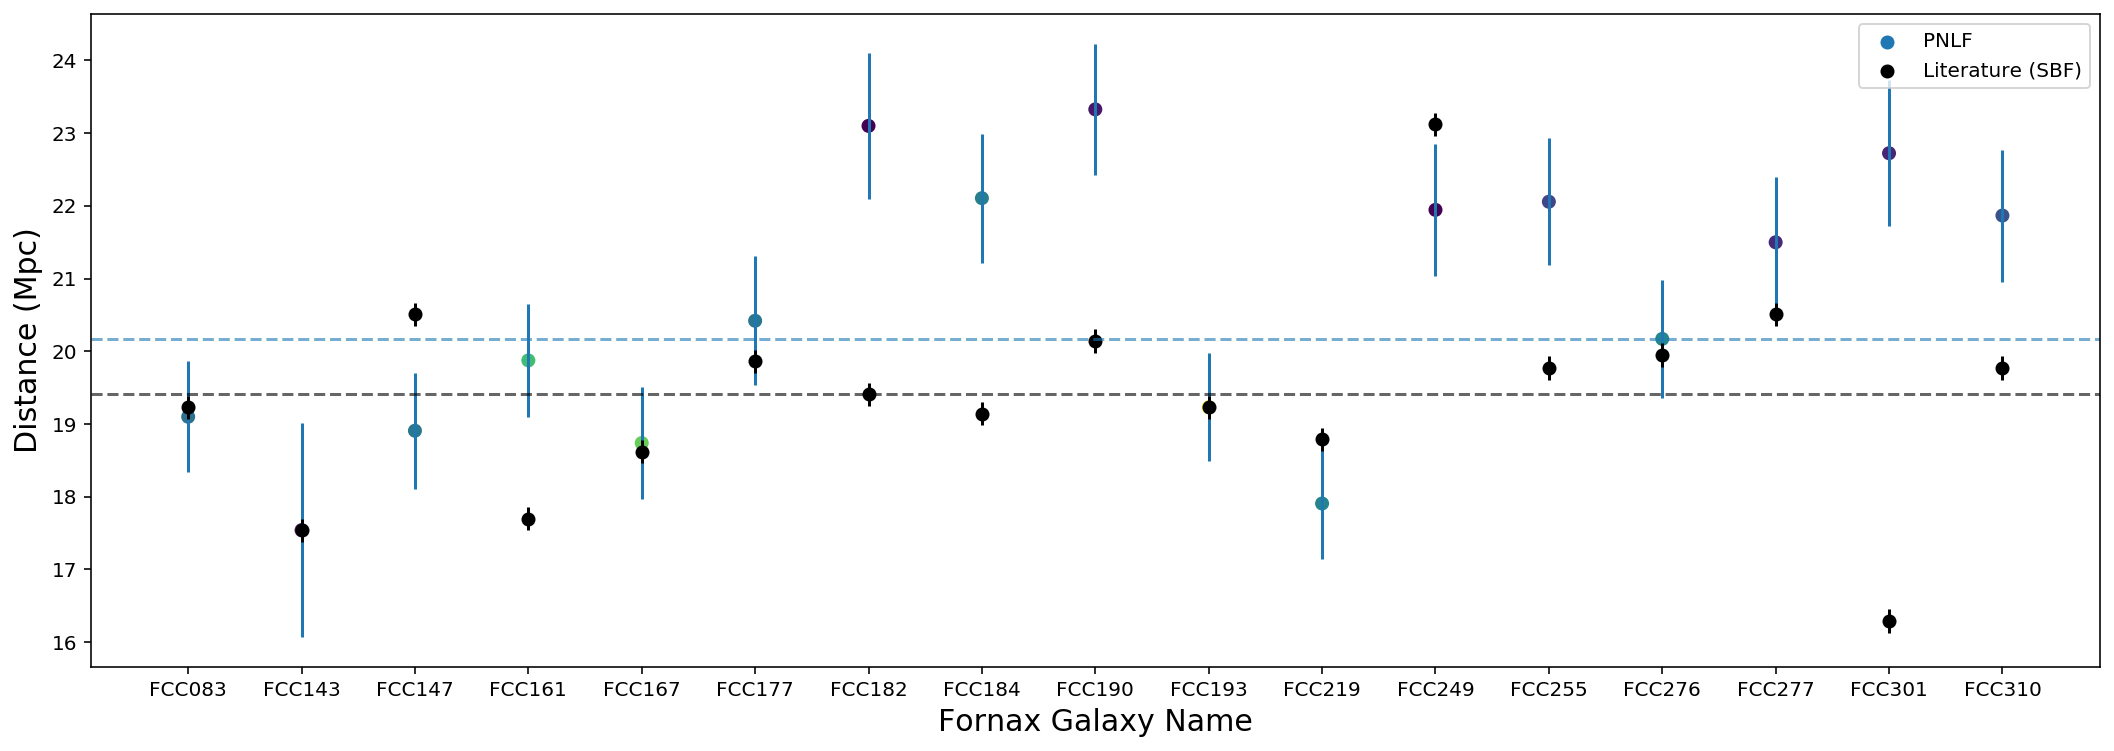

In [10]:
plt.figure(figsize=(18,6))
plt.scatter(galaxy_df["Galaxy"], galaxy_df["D PNLF"], label="PNLF", c=galaxy_df["PNe N"], zorder=0)
plt.scatter(galaxy_df["Galaxy"], galaxy_df["lit D"], label="Literature (SBF)", c="k")
plt.errorbar(galaxy_df["Galaxy"], galaxy_df["D PNLF"], yerr=galaxy_df["D PNLF err"], ls="None", zorder=1)
plt.errorbar(galaxy_df["Galaxy"], galaxy_df["lit D"], yerr=0.16, ls="None", c="k")
plt.axhline(galaxy_df["D PNLF"].loc[galaxy_df["PNe N"]>20].median(), ls="--", alpha=0.6)
plt.axhline(galaxy_df["lit D"].median(), c="k", ls="--", alpha=0.6)
plt.legend()
plt.ylabel("Distance (Mpc)", fontsize=15)
plt.xlabel("Fornax Galaxy Name", fontsize=15)
#plt.savefig("Plots/Distance_comp_lit.png", bbox_inches='tight')

Text(0.5, 0, 'NUV - R')

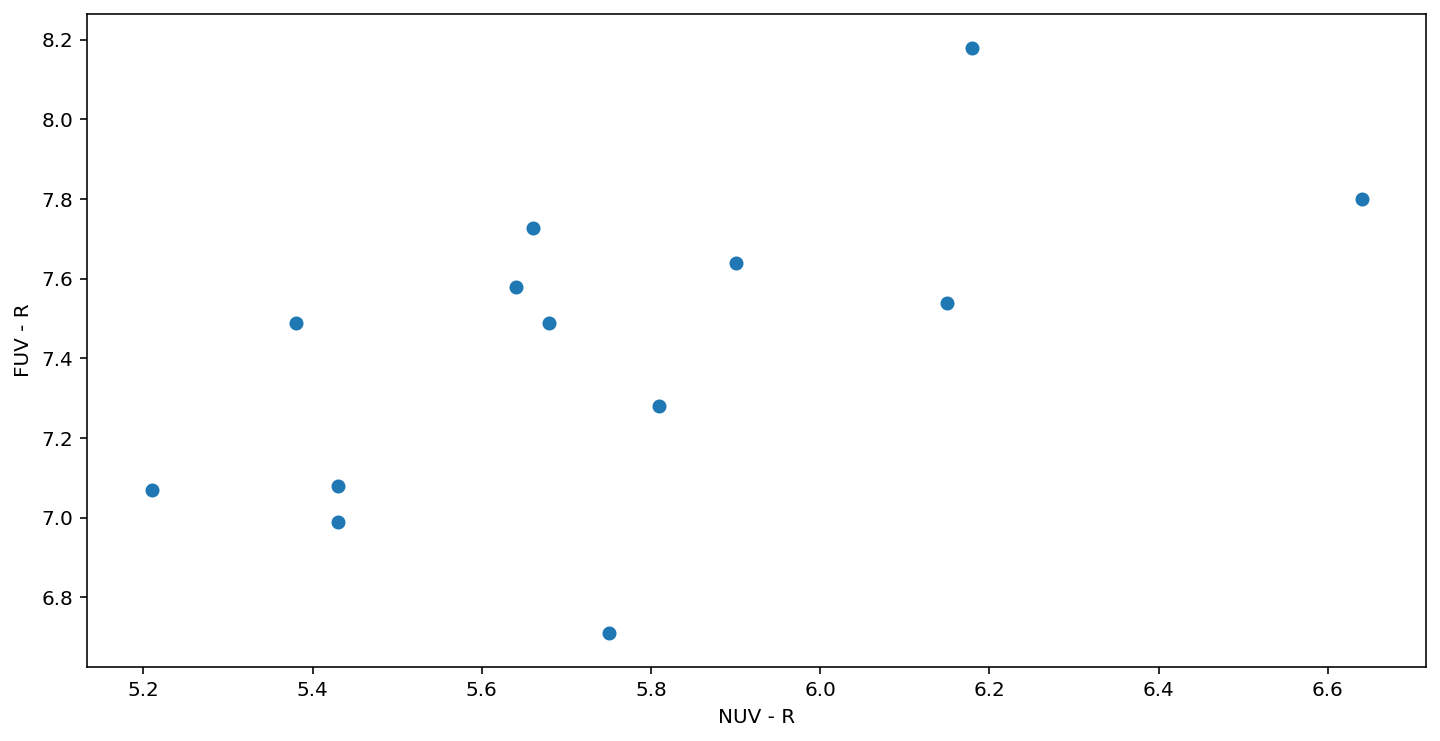

In [28]:
plt.figure(figsize=(12, 6))
plt.scatter(galaxy_df["NUV"] - galaxy_df["Rmag"], galaxy_df["FUV-R"])
plt.ylabel("FUV - R")
plt.xlabel("NUV - R")

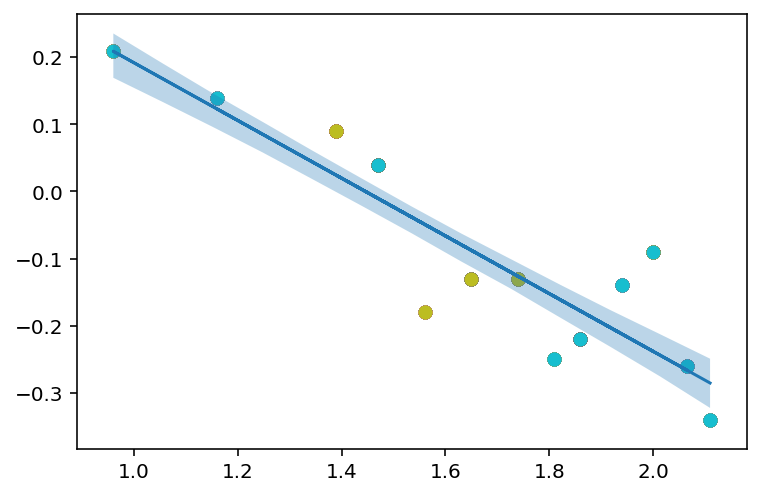

In [159]:
from astropy.stats import bootstrap
from astropy.utils import NumpyRNGContext
from scipy import stats


boot_1 = galaxy_df["FUV-NUV"].loc[pd.notnull(galaxy_df["FUV-NUV"])].values[1:]
boot_2 = galaxy_df["M/H"].loc[pd.notnull(galaxy_df["FUV-NUV"])].values[1:]
boot_arr = np.array([[i,j] for i,j in zip(boot_1, boot_2)])

num = 1000

with NumpyRNGContext(1):
    bootresult_1 = bootstrap(boot_arr, num) # FUV -NUV
#     bootresult_2 = bootstrap(boot_2, 1) # M/H

slope_list = np.ones(num)
intercept_list = np.ones(num)
std_err_list = np.ones(num)

for n in np.arange(num):
    plt.scatter(bootresult_1[n,:,0],bootresult_1[n,:,1])
    slope_list[n], intercept_list[n], r_value, p_value, std_err_list[n] = stats.linregress(bootresult_1[n,:,0],bootresult_1[n,:,1])
    #plt.plot(boot_1, slope_list[n]*boot_1+intercept_list[n], c="k", alpha=0.1)
    
med_slope = np.nanmedian(slope_list)
slope_16 = np.nanpercentile(slope_list, 16)
slope_84 = np.nanpercentile(slope_list, 84)


med_int = np.nanmedian(intercept_list)
int_16 = np.nanpercentile(intercept_list, 16)
int_84 = np.nanpercentile(intercept_list, 84)

std_err_med = np.nanmedian(std_err_list)
# plt.ylabel("M/H")
y = med_slope*boot_1 + med_int
plt.plot(boot_1, y)
x_axis = np.linspace(boot_1.min(), boot_1.max(), num=len(boot_1))

#plt.fill_between(x_axis, y_lo, y_up, alpha=0.5)

y_model = [np.array(s*x_axis + i, dtype=float) for s,i in zip(slope_list, intercept_list)]
med_y = np.array([np.nanmedian(y_model,axis=0) for m in y_model], dtype=float)
y_16 = np.array(np.nanpercentile(y_model, 16,axis=0) , dtype=float)
y_84 = np.array(np.nanpercentile(y_model, 84,axis=0) , dtype=float)

plt.fill_between(np.array(x_axis, dtype=float), y_16, y_84, alpha=0.3)


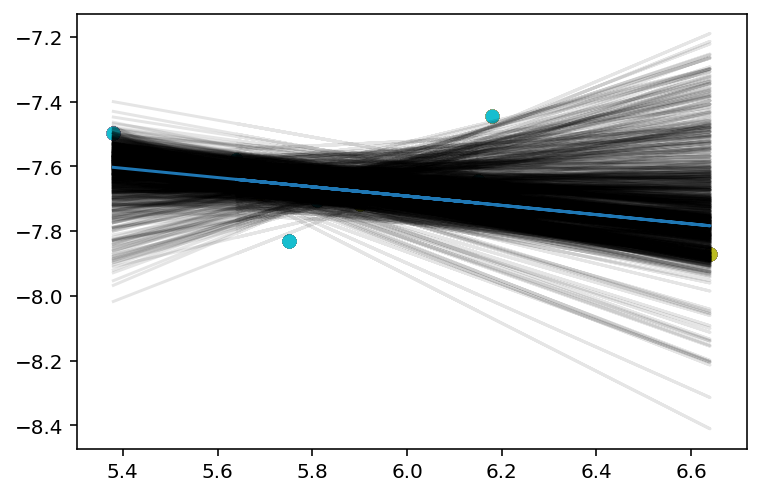

In [123]:
from astropy.stats import bootstrap
from astropy.utils import NumpyRNGContext

galaxy_df["NUV-R"] = galaxy_df["NUV"] - galaxy_df["Rmag"]


boot_1 = galaxy_df["NUV-R"].loc[pd.notnull(galaxy_df["NUV-R"]) & (galaxy_df["PNe N"]>20)].values
boot_2 = galaxy_df["alpha2.5"].loc[pd.notnull(galaxy_df["NUV-R"])& (galaxy_df["PNe N"]>20)].values
boot_arr = np.array([[i,j] for i,j in zip(boot_1, boot_2)])

num = 1000

with NumpyRNGContext(1):
    bootresult_1 = bootstrap(boot_arr, num) # FUV -NUV
#     bootresult_2 = bootstrap(boot_2, 1) # M/H

slope_list = np.ones(num)
intercept_list = np.ones(num)
std_err_list = np.ones(num)

for n in np.arange(num):
    plt.scatter(bootresult_1[n,:,0],bootresult_1[n,:,1])
    slope_list[n], intercept_list[n], r_value, p_value, std_err_list[n] = stats.linregress(bootresult_1[n,:,0],bootresult_1[n,:,1])
    plt.plot(boot_1, slope_list[n]*boot_1+intercept_list[n], c="k", alpha=0.1)
med_slope = np.nanmedian(slope_list)
slope_16 = np.nanpercentile(slope_list, 16)
slope_84 = np.nanpercentile(slope_list, 84)


med_int = np.nanmedian(intercept_list)
int_16 = np.nanpercentile(intercept_list, 16)
int_84 = np.nanpercentile(intercept_list, 84)

std_err_med = np.nanmedian(std_err_list)
# plt.ylabel("M/H")
y = med_slope*boot_1 + med_int
plt.plot(boot_1, y)
x_axis = np.linspace(boot_1.min(), boot_1.max(), num=len(boot_1))

y_up = np.array(slope_84*boot_1 + int_84, dtype=float)
y_lo = np.array(slope_16*boot_1 + int_16, dtype=float)

#plt.fill_between(x_axis, y_lo, y_up, alpha=0.5)



Text(0.5, 0, 'FUV-NUV')

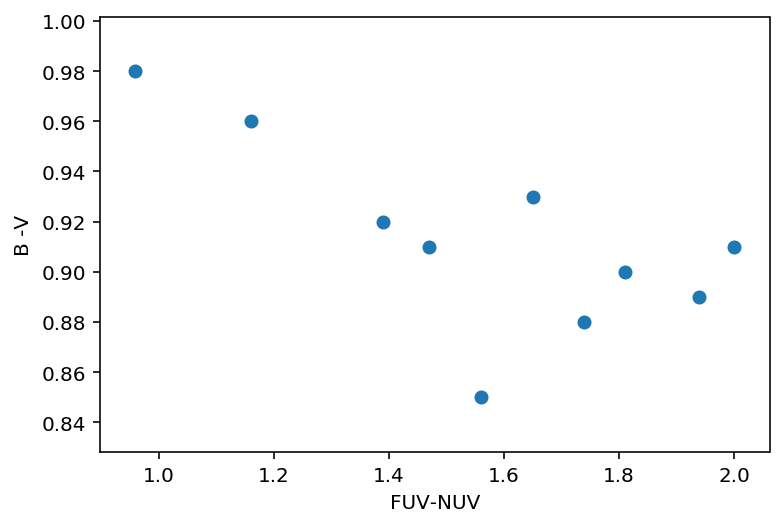

In [173]:
plt.scatter(galaxy_df["FUV-NUV"], galaxy_df["B-V"])
plt.ylabel("B -V")
plt.xlabel("FUV-NUV")